# New Mismatch - V2
### Clean start on mismatch calculations with a few things in mind:
1. Mismatch calculated for low speed. Mismatch calculated for high speed. 
    - May want to do this calculation only stimulus period so that “inhibition” is also included
2. Mismatch trials 
    - Norm to maximum pre/post reversal 
    - Could do each trial or each run/day imaging session
3. For offset cells, do heatmap with ensure delivery sort, and lick onset sort. Do trial do trial for a day L5
    - Could go back for same cells L1 and look at Pavlovians 

In [1]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import warnings
from cascade import utils
from scipy.stats import pearsonr
from copy import deepcopy

## load data

In [2]:
# set parameters
mice = cas.lookups.mice['all12']
# words = ['facilitate'] * len(mice)
words = ['respondent' if s in 'OA27' else 'computation' for s in mice]
group_by = 'all3'

rank_level_sort = 15

# mice = ['OA27']
# words = ['bookmarks']

# load in a full size tensor
model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    
    # return   model, ids, tensor, meta, bhv
    out = cas.load.load_all_groupday(mouse, word=word, with_model=True, group_by=group_by, nan_thresh=0.95)
    sorted_model, sort_order = utils.sortfactors(out[0])
    model_list.append(sorted_model)
    tensor_list.append(out[2][sort_order[rank_level_sort - 1], :, :])
    id_list.append(out[1][sort_order[rank_level_sort - 1]])
    bhv_list.append(out[4])
    meta_list.append(utils.add_stages_to_meta(out[3], 'parsed_11stage'))

Updated naive cs-ori pairings to match learning.
     135 plus
     270 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     0 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match le

## build preferred tensors and tuning df for easy indexing

In [3]:
pref_tensor_list = []
cell_tuning_list = []
for meta, tensor, model in zip(meta_list, tensor_list, model_list):
    ten, tun = cas.tuning.preferred_tensor(meta, tensor, model, tune_staging='staging_LR', best_tuning_only=True, drop_broad_tuning=False,
                                           staging='parsed_11stage', tuning_type='initial', return_tuning=True)
    pref_tensor_list.append(ten)
    cell_tuning_list.append(tun)

s:\twophoton_analysis\code\cascade\cascade\utils.py:1601: RuntimeWarning: All-NaN slice encountered
  above_thresh = ~np.isnan(np.nanmax(weights, axis=1))
s:\twophoton_analysis\code\cascade\cascade\tuning.py:80: RuntimeWarning: Mean of empty slice
  trial_avg_vec = np.nanmean(cell_mat, axis=0)
s:\twophoton_analysis\code\cascade\cascade\tuning.py:358: RuntimeWarning: Mean of empty slice
  mean_cue.append(np.nanmean(rect_trial_avg_vec[cue_boo]))
s:\twophoton_analysis\code\cascade\cascade\tuning.py:410: RuntimeWarning: Mean of empty slice
  mean_cue.append(np.nanmean(rect_trial_avg_vec[cue_boo]))


### *build cell tuning df*

In [4]:
cellt_df = pd.concat(cell_tuning_list, axis=0).set_index(['mouse', 'cell_n'])
cellt_df.head()

learning_tuning reversal1_tuning
mouse cell_n                                 
AS20  1                 plus             plus
      2                 plus             plus
      3                 plus             none
      4                 plus             plus
      5                 plus             plus

In [15]:
LR_tuning = []
for ids, tun in zip(id_list, cell_tuning_list):
    tun = tun.copy()
    tun['cell_id'] = ids
    LR_tuning.append(tun)
celltid_df = pd.concat(LR_tuning, axis=0).set_index(['mouse', 'cell_id']).sort_index()
celltid_df.head()

cell_n learning_tuning reversal1_tuning
mouse cell_id                                         
AS20  1           447           broad            broad
      2           445           broad            broad
      3           446   neutral-minus            broad
      4           371           broad            broad
      5            60   minus-neutral       minus-plus

In [16]:
celltid_df.to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_LRtuning_wids.pkl')

In [104]:
for mouse, pref_tensor in zip(mice, pref_tensor_list):
    np.save(f'/twophoton_analysis/Data/analysis/Group-attractive/{mouse}_pref_tensor_compresp_nsort.npy', pref_tensor)

## calulcate mismatch two ways 
1. for low pre stimulus running
2. for high pre stimulus running

Iterating:
1. add_in HMM

### A. running thresholds

In [5]:
rmm_list_low, rmm_list_high = [], []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='low_pre_speed_only', filter_licking=None,
                                filter_hmm_engaged=False, force_same_day_reversal=False,
                                use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_low.append(rmml)
    rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='high_pre_speed_only', filter_licking=None,
                            filter_hmm_engaged=False, force_same_day_reversal=False,
                            use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_high.append(rmmh)
    

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


### *make full size dfs*

In [6]:
rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])
rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

### B. matching running bins - using stim period for all 

In [5]:
rmm_list_match = []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmm_m = cas.mismatch.run_controlled_naive_mismatch(meta, pref_tensor, filter_licking=None, filter_running=None,
                                  filter_hmm_engaged=True, boot=True, account_for_offset=False)
    rmm_list_match.append(rmm_m)

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:1814: RuntimeWarning: Mean of empty slice
  binned_set1[:, bc] = np.nanmean(set1_tensor[:, bin_trials1], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:315: RuntimeWarning: Mean of empty slice
  reversal_mismatch = np.nanmean(post_bins - pre_bins, axis=1)


  -->  AS20: pre-rev: 982, post-rev: 100


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:331: RuntimeWarning: Mean of empty slice
  boot_mat[:, booti] = np.nanmean(post_bins - pre_bins, axis=1)


  -->  AS20: significant mismatch: n = 37
Mouse AS20 did not have L0 naive.
  -->  AS23: pre-rev: 1000, post-rev: 100
  -->  AS23: significant mismatch: n = 56
Mouse AS23 did not have L0 naive.
Mouse AS41 did not have any reversal.
Mouse AS41 did not have L0 naive.
Mouse AS47 did not have any reversal.
  -->  AS47: naive: 1000, learning-start: 97


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:376: RuntimeWarning: Mean of empty slice
  learn_mismatch = np.nanmean(post_learn_bins - pre_learn_bins, axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:392: RuntimeWarning: Mean of empty slice
  boot_mat[:, booti] = np.nanmean(post_bins - pre_bins, axis=1)


  -->  AS47: significant mismatch: n = 0
  -->  OA26: pre-rev: 1000, post-rev: 90
  -->  OA26: significant mismatch: n = 51
  -->  OA26: naive: 655, learning-start: 100
  -->  OA26: significant mismatch: n = 17
  -->  OA27: pre-rev: 711, post-rev: 100
  -->  OA27: significant mismatch: n = 84
  -->  OA27: naive: 414, learning-start: 81
  -->  OA27: significant mismatch: n = 18
  -->  OA32: pre-rev: 1000, post-rev: 100
  -->  OA32: significant mismatch: n = 59
Mouse OA32 did not have L0 naive.
  -->  OA34: pre-rev: 801, post-rev: 34
  -->  OA34: significant mismatch: n = 61
Mouse OA34 did not have L0 naive.
  -->  OA36: pre-rev: 994, post-rev: 21
  -->  OA36: significant mismatch: n = 31
Mouse OA36 did not have L0 naive.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have L0 naive.
  -->  OA67: pre-rev: 985, post-rev: 100
  -->  OA67: significant mismatch: n = 49
  -->  OA67: naive: 487, learning-start: 9
  -->  OA67: significant mismatch: n = 24
  -->  VF226: pre-rev: 986, po

In [12]:
new_rmmwid_list = []
for rm, ids in zip(rmm_list_match, id_list):
    rm = rm.copy()
    rm['cell_id'] = ids
    new_rmmwid_list.append(rm)
rmmwid = pd.concat(new_rmmwid_list, axis=0).reset_index(drop=True).set_index(['mouse', 'cell_id']).sort_index()
rmmwid.head() 

cell_n  lMM_response  lMM_pvals  rMM_response  rMM_pvals
mouse cell_id                                                          
AS20  1           447           NaN        NaN      0.134144      0.062
      2           445           NaN        NaN     -0.000249      0.423
      3           446           NaN        NaN     -0.406498      0.027
      4           371           NaN        NaN     -0.053590      0.276
      5            60           NaN        NaN      0.211288      0.102

### *save*
- Offset cells here have been assessed for mismatch based on their stimulus response period
- this is with run matching on 3 cm/s bins
- using 1000 pre and 100 post for mismatch calc
- pvals calculated by boot strapping

In [13]:
rmmwid.to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_rMMrc_df_wids.pkl')

## calculate correlation with running 

In [49]:
runcorr_list = []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    run = cas.stability.correlate_wrunning_per_trial(meta, pref_tensor, epoch='parsed_11stage', account_for_offset=False)
    runcorr_list.append(run)

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\stability.py:1076: RuntimeWarning: Mean of empty slice
  new_mat[:, c] = np.nanmean(corr_days, axis=1)


### *make an average running corr df*

In [50]:
run_df_list = []
for run, meta, ids in zip(runcorr_list, meta_list, id_list):
    run_corr_vec = np.nanmean(run, axis=1) # average across stages of learning
    rdf = pd.DataFrame(
        {'mouse': [meta.reset_index().mouse.unique()[0]] * len(run_corr_vec),
         'cell_n': np.arange(len(run_corr_vec)) + 1,
         'cell_id': ids,
         'mean_run_corr': run_corr_vec,
         'L5_run_corr': run[:, 5],
         'R5_run_corr': run[:, 6]
        }
    )
    run_df_list.append(rdf)
run_df = pd.concat(run_df_list, axis=0).set_index(['mouse', 'cell_n'])
run_df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


cell_id  mean_run_corr  L5_run_corr  R5_run_corr
mouse cell_n                                                  
AS20  1           525       0.348010     0.320854     0.235171
      2           164       0.561076     0.174151     0.567942
      3           187       0.055618    -0.138632          NaN
      4           118       0.404083    -0.102070     0.240663
      5           339       0.188866    -0.220048     0.158799

In [53]:
# save
run_df.reset_index().set_index(['mouse', 'cell_id']).sort_index() \
    .to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_stim_runcorr.pkl')

### *load baseline running corr*

In [24]:
base_run_corr = pd.read_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_baseline_runcorr.pkl')

In [25]:
# add cell_n column to baseline running corr
base_run_corr = base_run_corr.join(rmmwid.cell_n)
base_run_corr.head()

parsed_11stage  baseline_running_correlation  cell_n
mouse cell_id                                                     
AS20  1             L0 naive                           NaN     447
      1          L1 learning                      0.225932     447
      1          L2 learning                      0.225932     447
      1          L3 learning                      0.225932     447
      1          L4 learning                      0.146497     447

## put useful dfs together

### *build a mismatch mapper*

In [17]:
mapping_mm = {}
for meta in meta_list:
    meta = cas.utils.add_reversal_mismatch_condition_to_meta(meta)
    pre_meta = meta.loc[meta.learning_state.isin(['learning'])]
    mouse = meta.reset_index().mouse.unique()[0]
    mapping_mm[mouse] = {}
    for cue in pre_meta.condition.unique():
        miscond = pre_meta.loc[pre_meta.condition.isin([cue]), 'mismatch_condition'].unique()[0]
        mapping_mm[mouse][cue] = miscond

### *for each mouse loop over tuning and remap for mismatch type*

In [20]:
remap_tune_list = []
for meta, tun, ids in zip(meta_list, cell_tuning_list, id_list):
    
    mouse = meta.reset_index().mouse.unique()[0]
    
    # remap tuning for best tuning PMN, treating broad and none as having no possible mismatch
    remapped_tuning = tun.set_index(['mouse', 'cell_n']).learning_tuning.apply(
        lambda x: 'none' if x in ['broad', 'none'] else mapping_mm[mouse][x[:x.find('-')] if x.find('-') > 0 else x]).to_frame()
    remapped_tuning['cell_id'] = ids
    remap_tune_list.append(remapped_tuning.rename(columns={'learning_tuning': 'mm_tuning'}))
remap_tune_col = pd.concat(remap_tune_list, axis=0)
remap_tune_col.head()

mm_tuning  cell_id
mouse cell_n                             
AS20  1       becomes_unrewarded      525
      2       becomes_unrewarded      164
      3       becomes_unrewarded      187
      4       becomes_unrewarded      118
      5       becomes_unrewarded      339

### *finally put them all together*

In [11]:
all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                    rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), run_df, cellt_df, remap_tune_col], axis=1)
all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
all_df.head()

rMM_high   rMM_low  mean_run_corr  L5_run_corr  R5_run_corr  \
mouse cell_n                                                                
AS20  1       0.462068  1.663442       0.348010     0.320854     0.235171   
      2            NaN       NaN       0.561076     0.174151     0.567942   
      3            NaN       NaN       0.055618    -0.138632          NaN   
      4      -0.647644  1.296204       0.404083    -0.102070     0.240663   
      5      -0.629917 -0.182039       0.188866    -0.220048     0.158799   

             learning_tuning reversal1_tuning           mm_tuning  \
mouse cell_n                                                        
AS20  1                 plus             plus  becomes_unrewarded   
      2                 plus             plus  becomes_unrewarded   
      3                 plus             none  becomes_unrewarded   
      4                 plus             plus  becomes_unrewarded   
      5                 plus             plus  becomes_unrewarded   

             top_learning_tuning  
mouse cell_n                      
AS20  1                     plus  
      2                     plus  
      3                     plus  
      4                     plus  
      5                     plus

## plot mismatches against each other for high and low speed

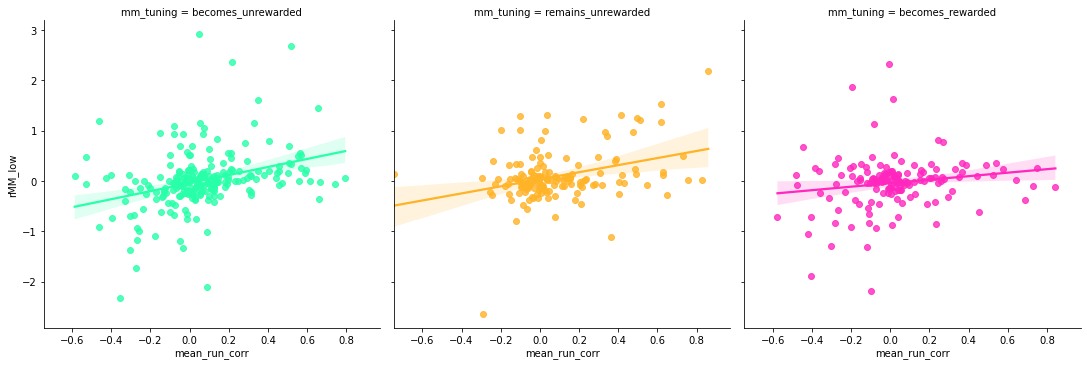

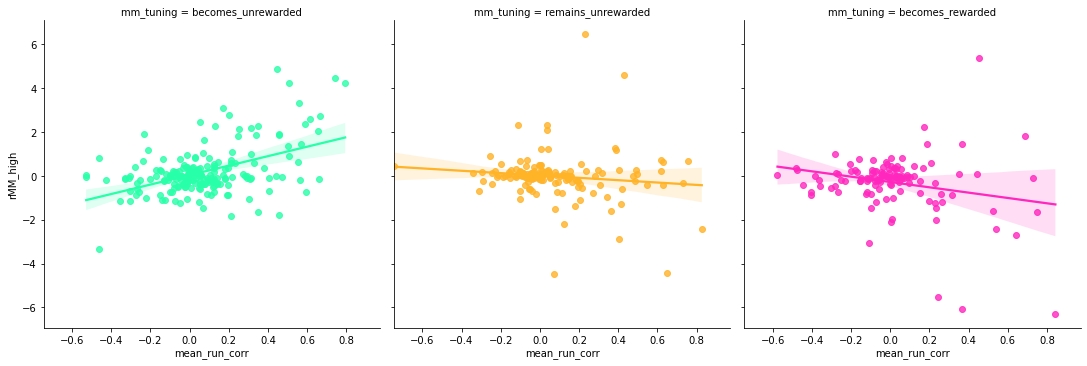

In [94]:
plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_low', hue='mm_tuning', col='mm_tuning', palette=cas.lookups.color_dict)
# plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/low.png')
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='mm_tuning', col='mm_tuning', palette=cas.lookups.color_dict)
# plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/high.png')
# plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablat

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


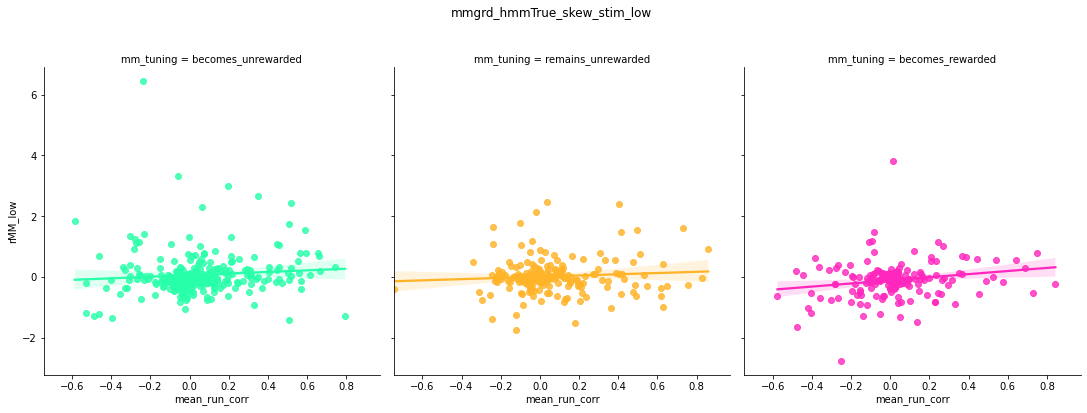

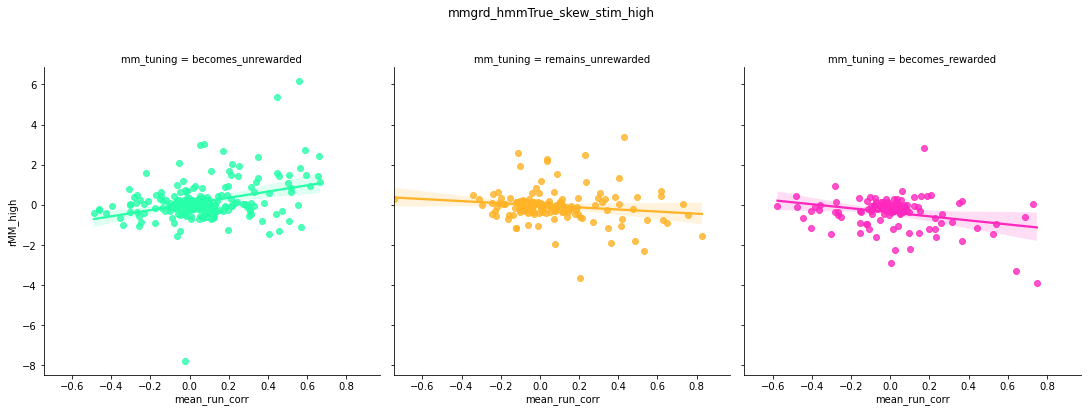

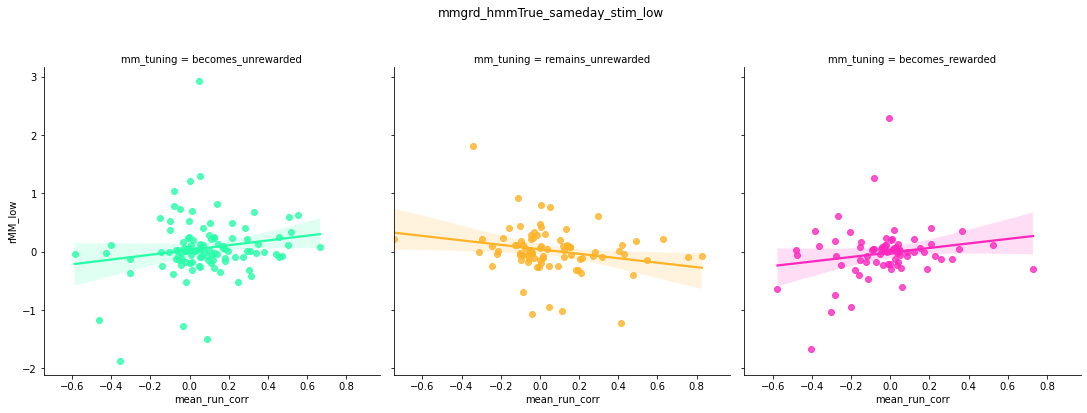

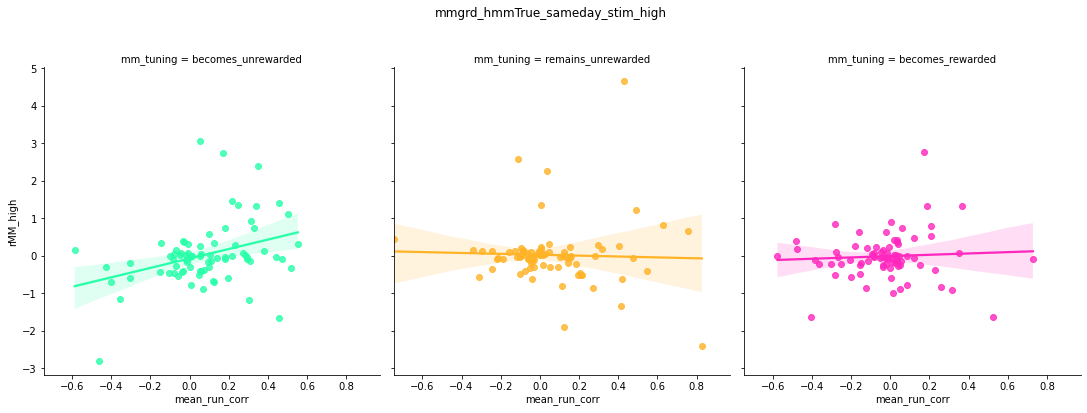

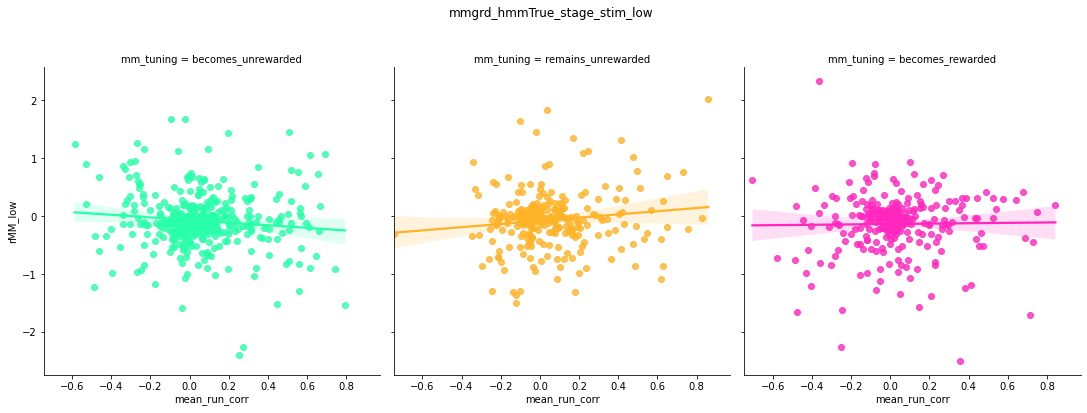

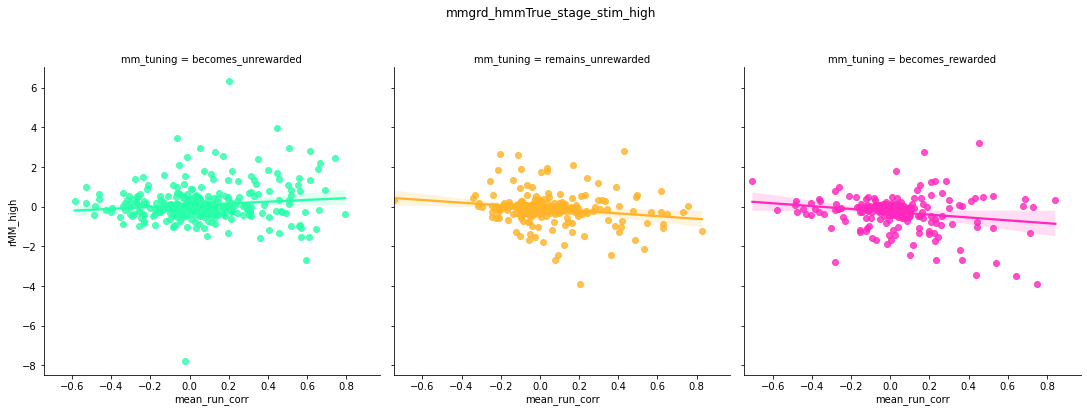

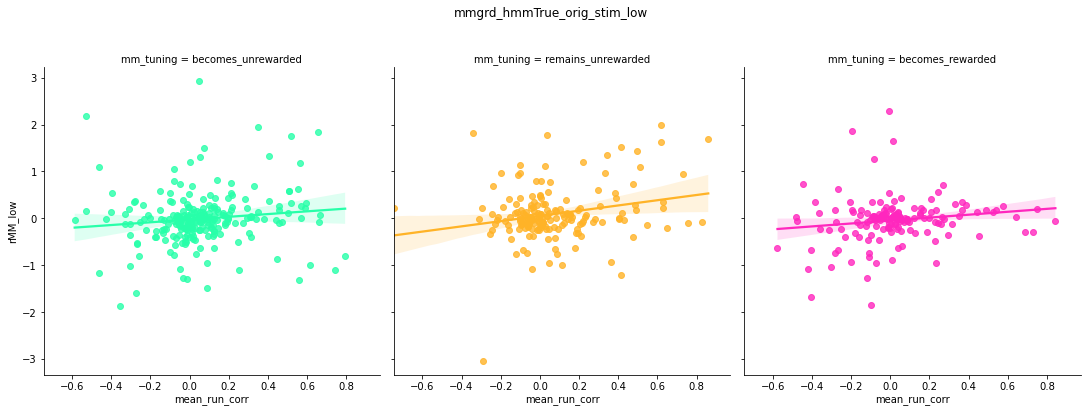

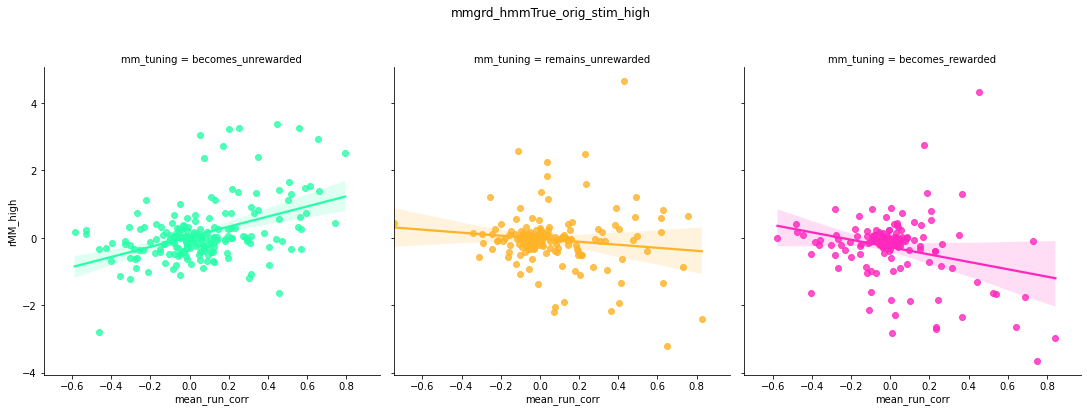

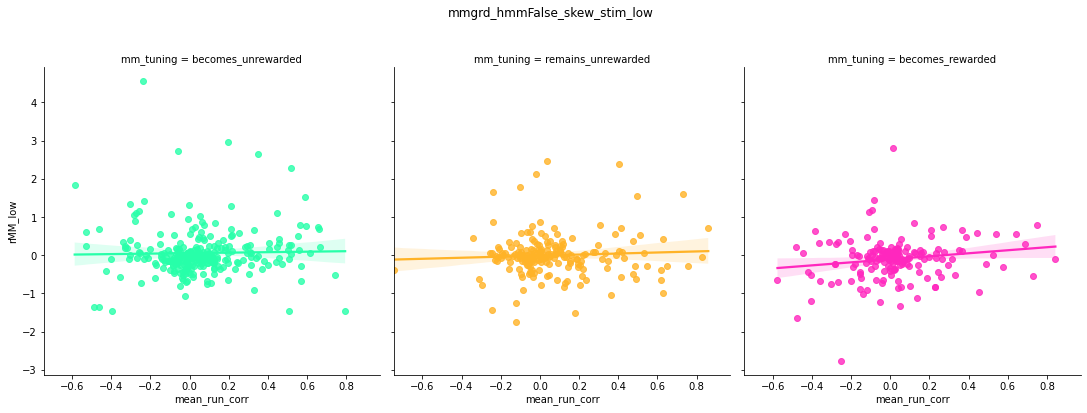

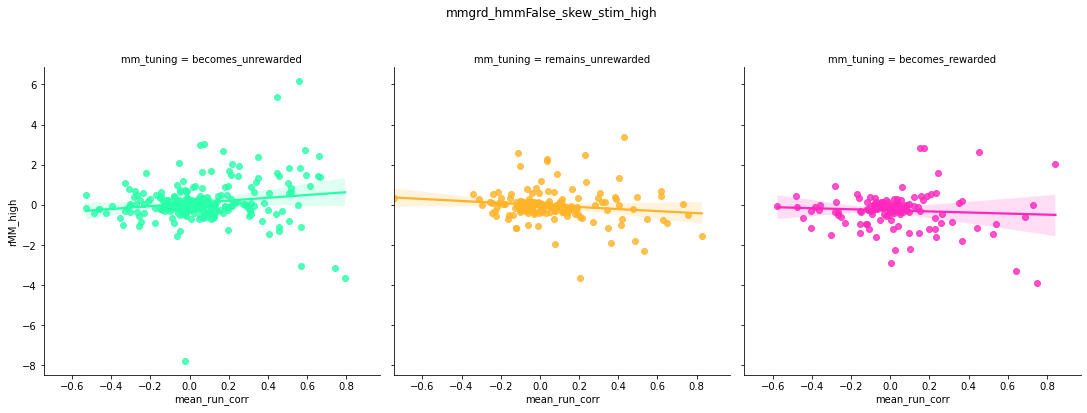

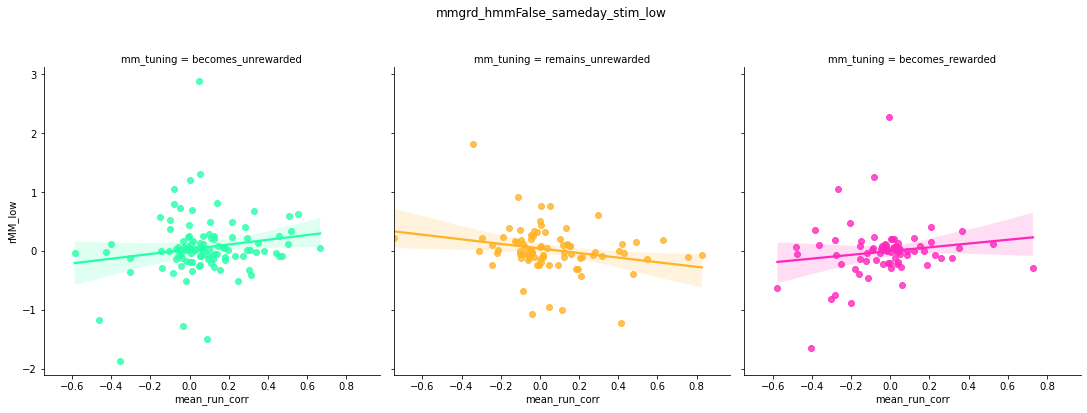

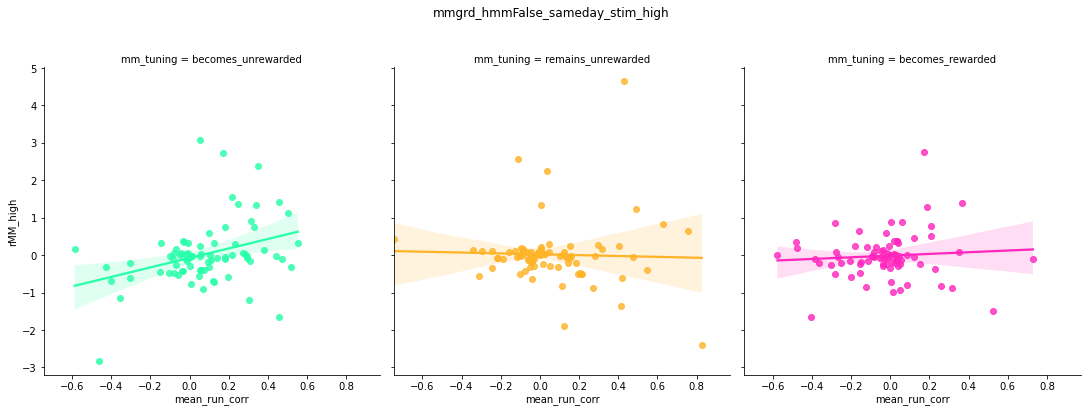

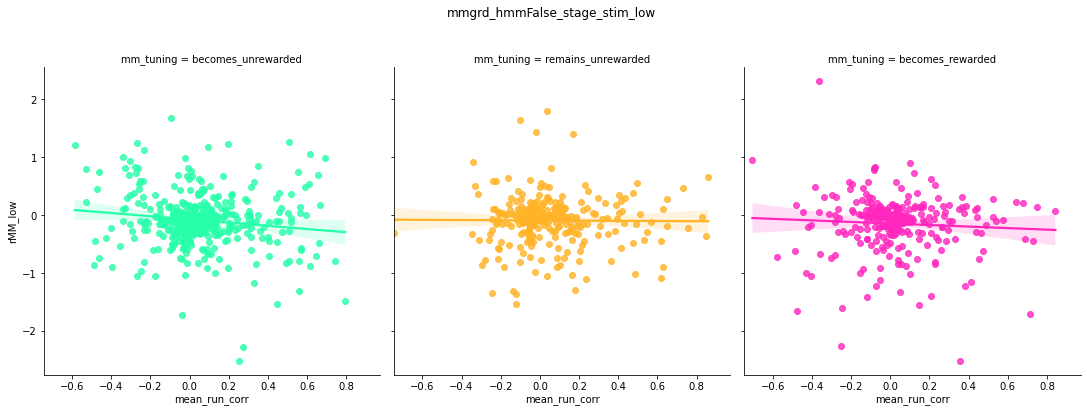

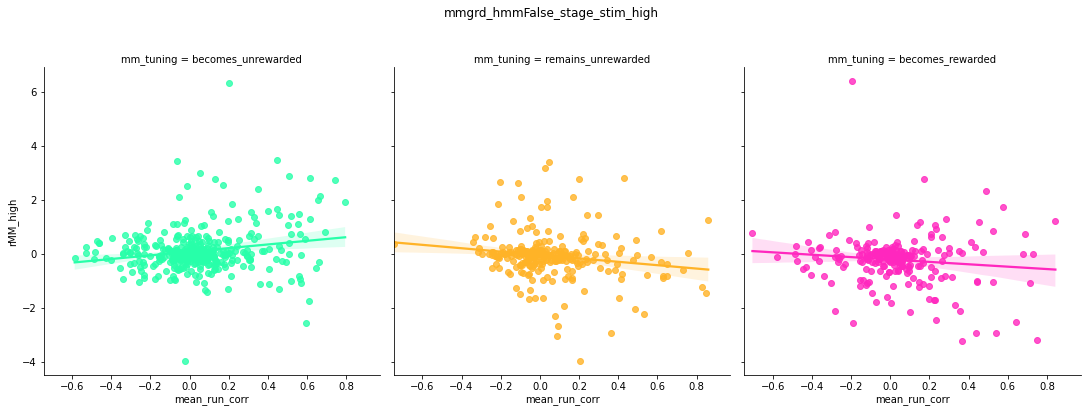

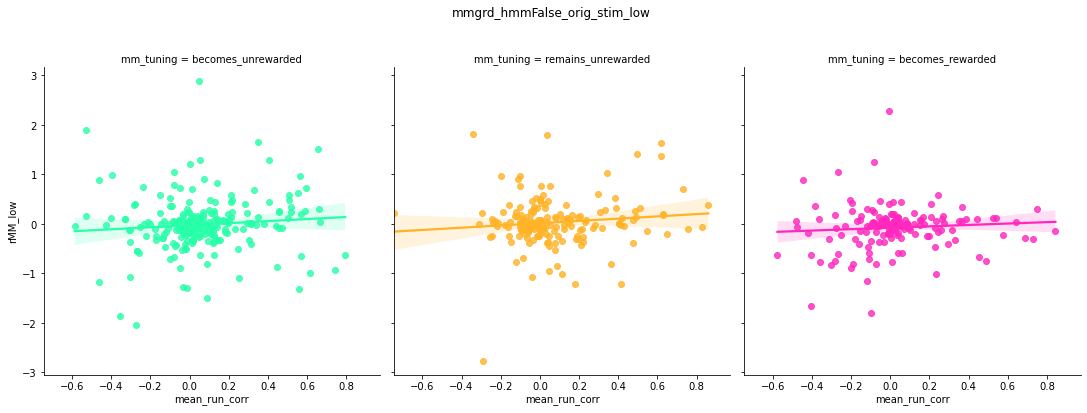

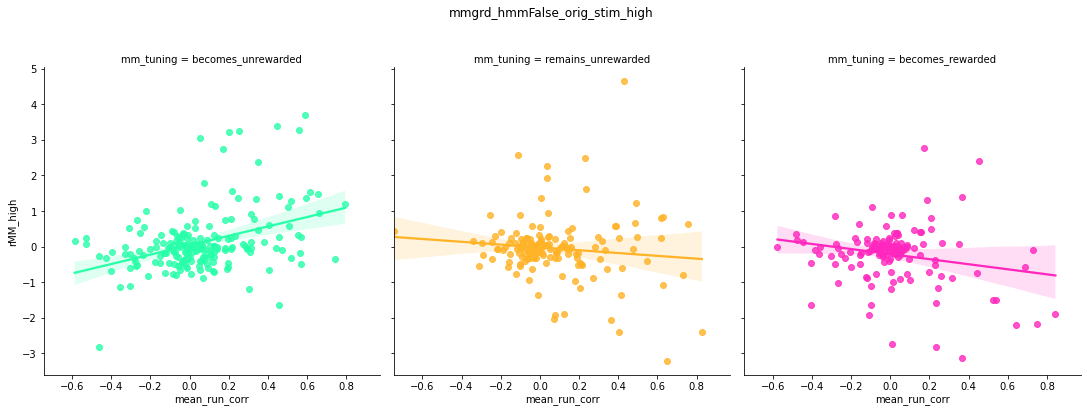

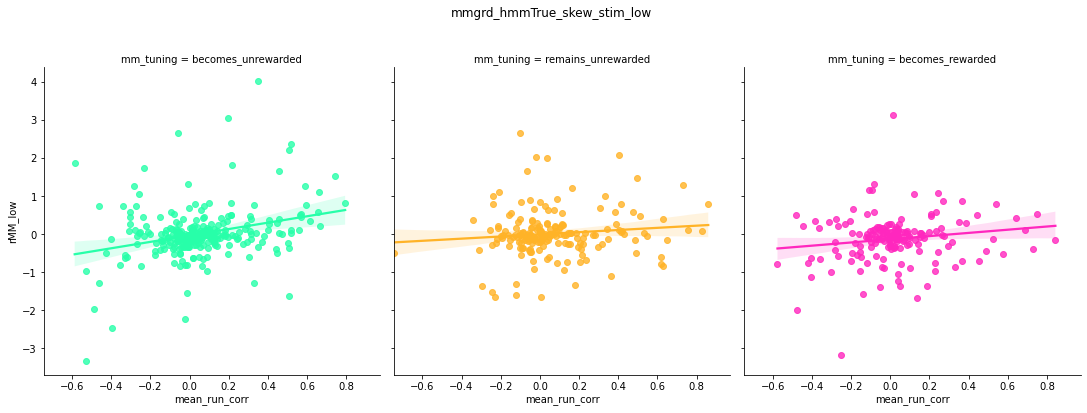

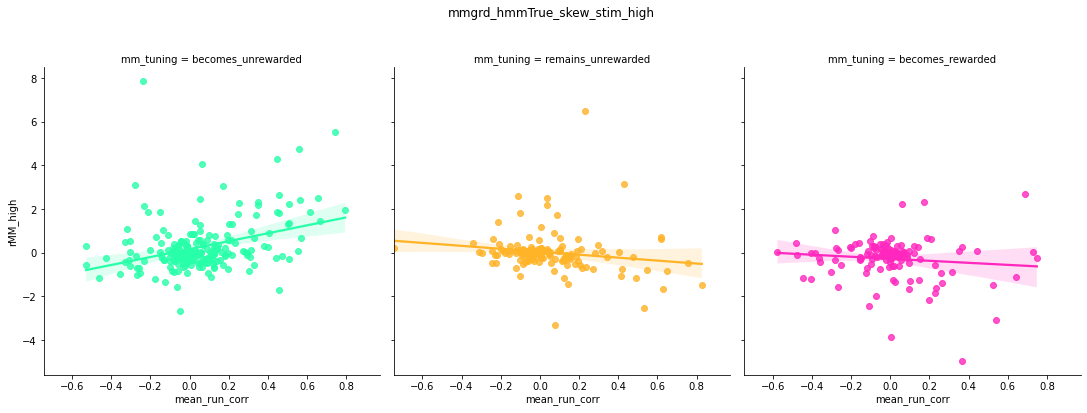

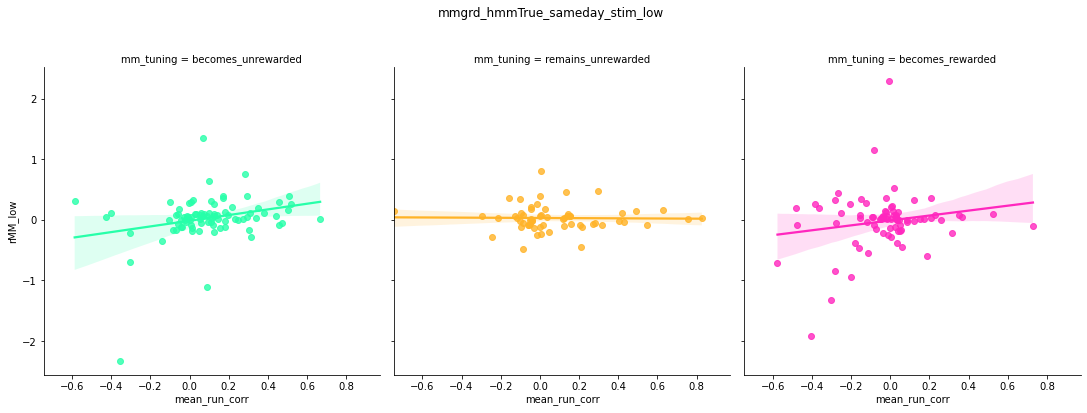

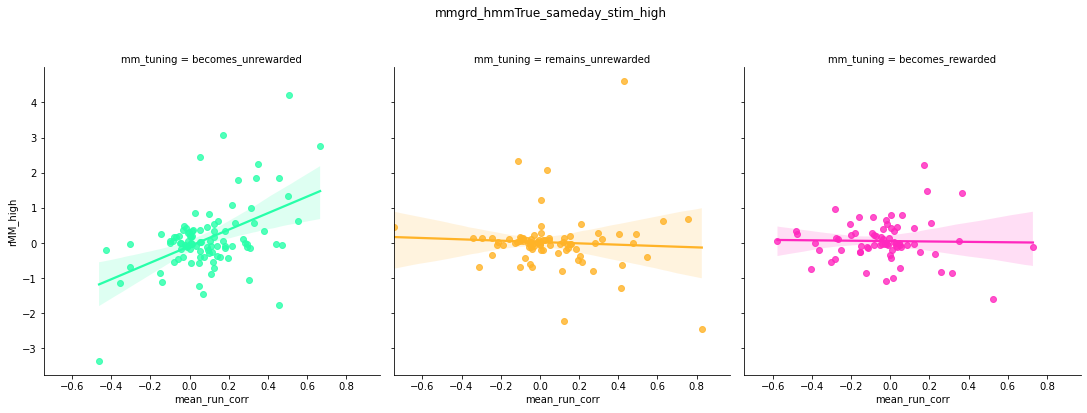

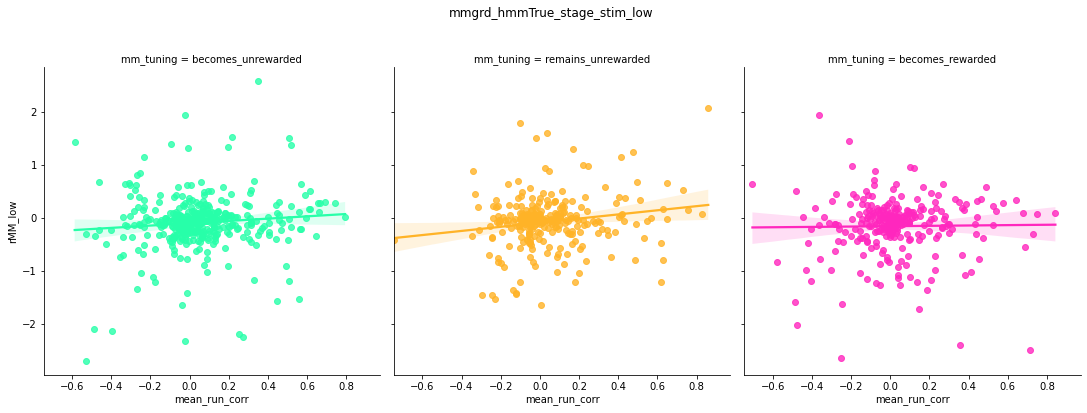

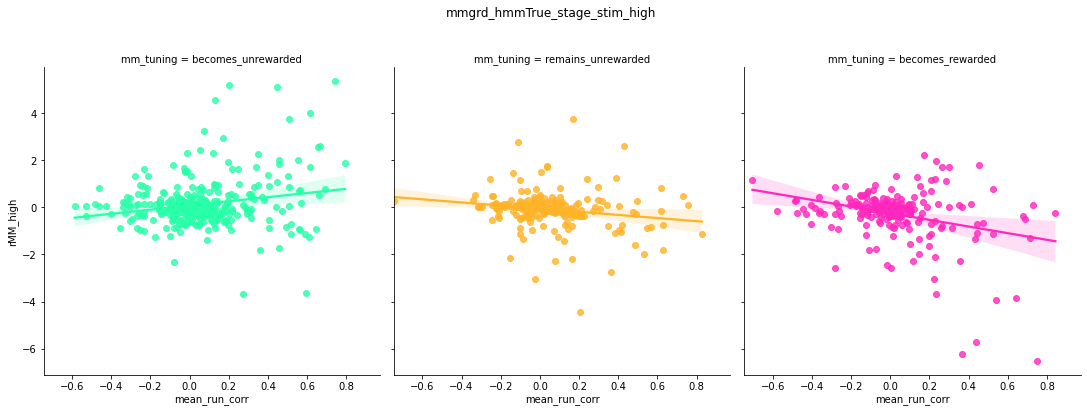

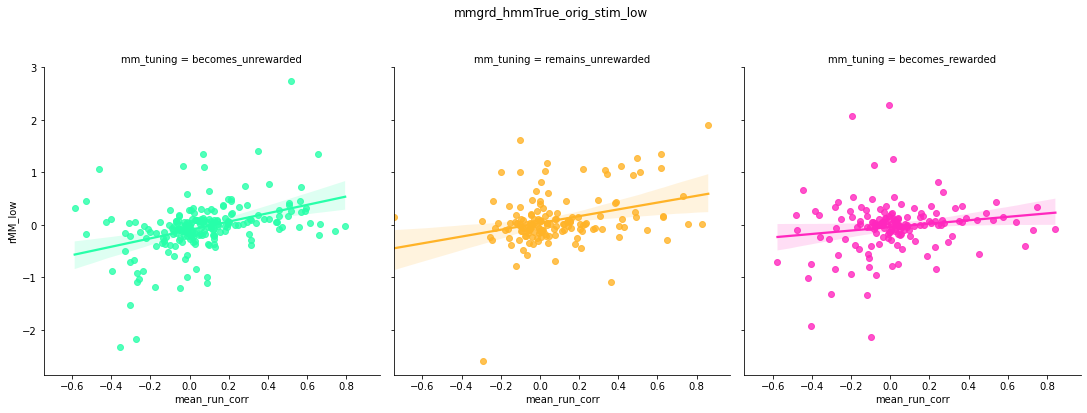

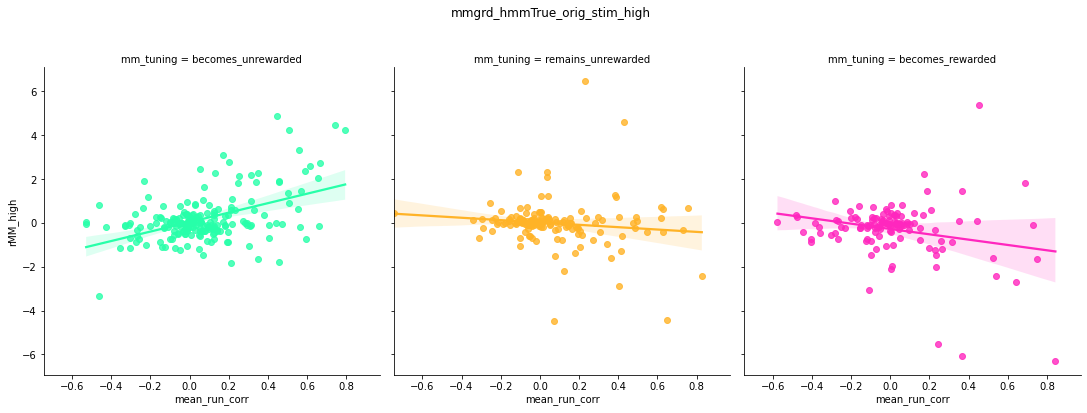

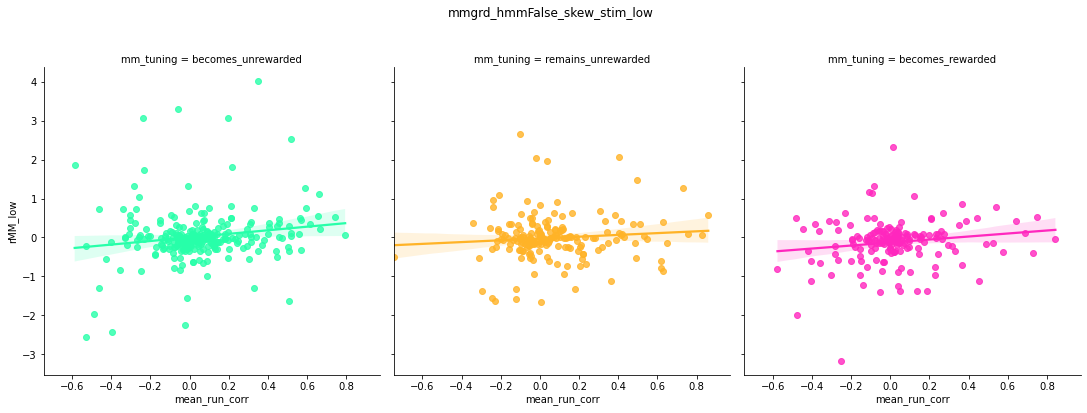

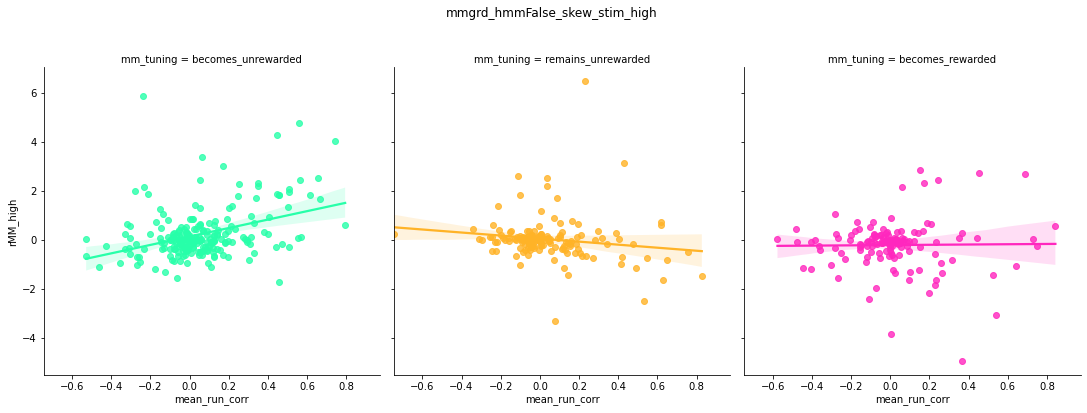

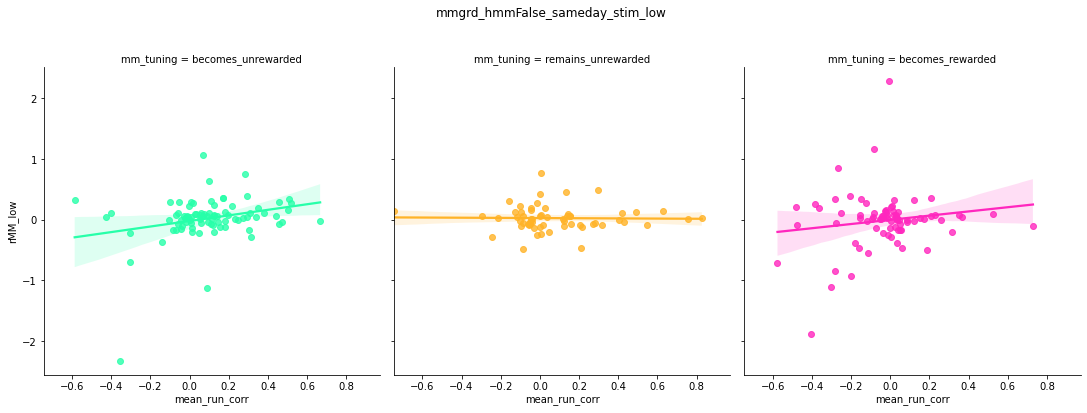

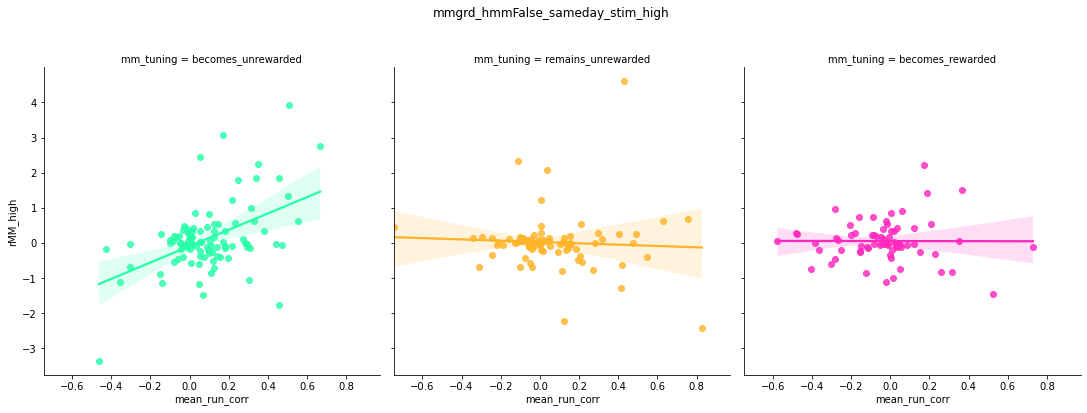

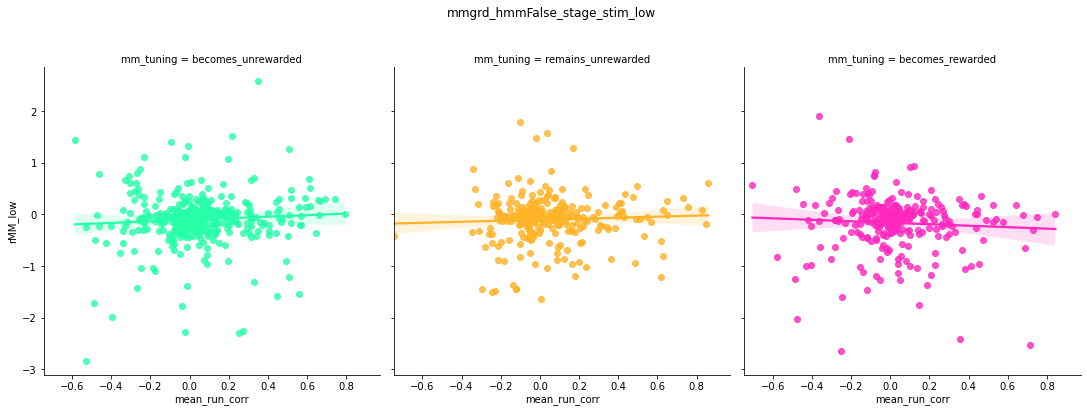

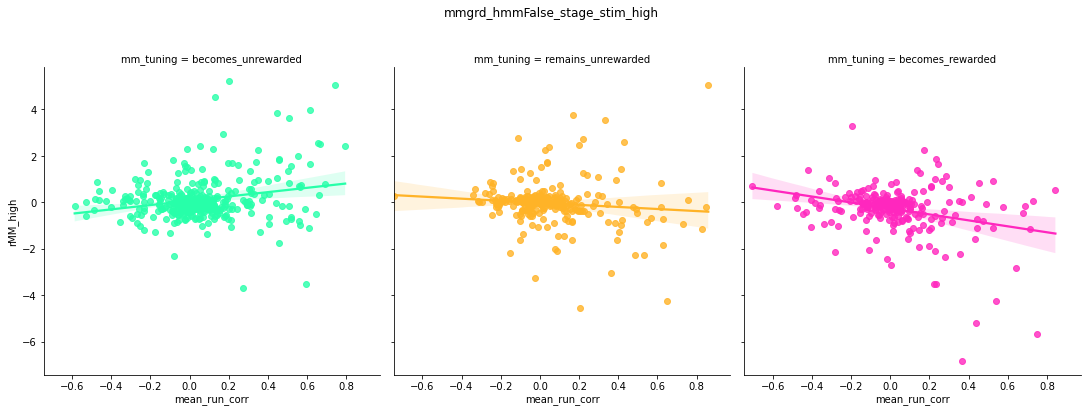

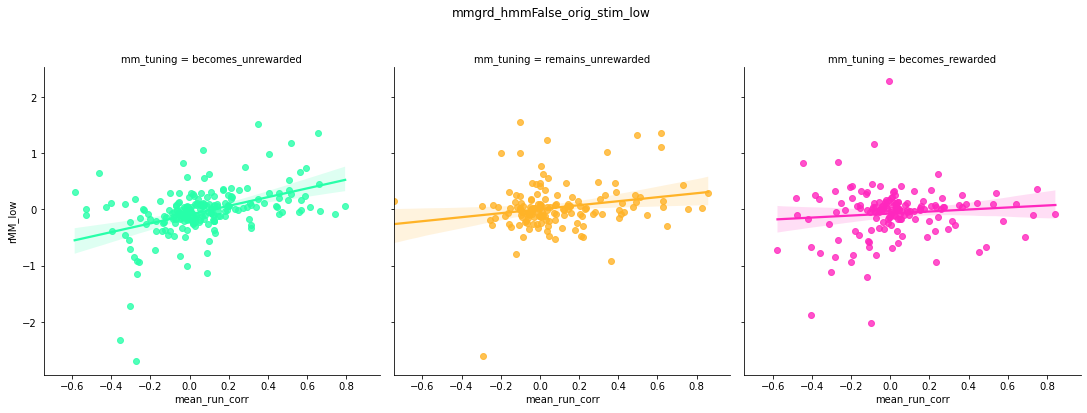

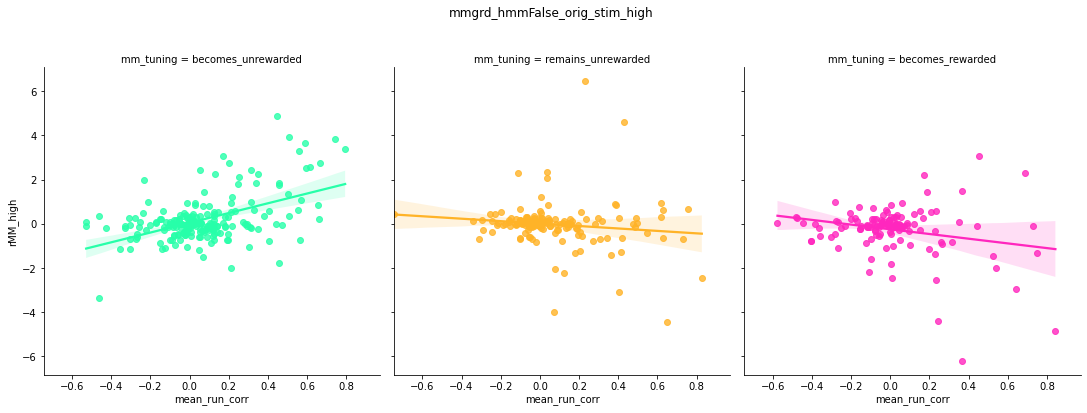

In [14]:
# Grid search
for s in [['high_pre_speed_only', 'low_pre_speed_only'], ['high_speed_only', 'low_speed_only']]:
    for h in [True, False]:
        for ty in ['skew', 'sameday', 'stage', 'orig']:
            if ty == 'skew':
                t1, t2, t3 = False, True, False
            elif ty == 'sameday':
                t1, t2, t3 = True, False, False
            elif ty == 'stage':
                t1, t2, t3 = False, False, True
            elif ty == 'orig':
                t1, t2, t3 = False, False, False

            rmm_list_low, rmm_list_high = [], []
            for meta, pref_tensor in zip(meta_list, pref_tensor_list):
                rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running=s[1], filter_licking=None,
                                            filter_hmm_engaged=h, force_same_day_reversal=t1,
                                            skew_stages_for_reversal=t2, use_stages_for_reversal=t3, account_for_offset=False)
                rmm_list_low.append(rmml)
                rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running=s[0], filter_licking=None,
                                        filter_hmm_engaged=h, force_same_day_reversal=t1,
                                        skew_stages_for_reversal=t2, use_stages_for_reversal=t3, account_for_offset=False)
                rmm_list_high.append(rmmh)

            rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])

            rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

            all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                                rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), run_df, cellt_df, remap_tune_col], axis=1)
            all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
            all_df.head()

            if s in ['high_pre_speed_only', 'low_pre_speed_only']:
                runtag = 'pre'
            else:
                runtag = 'stim'

            plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
            sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_low', hue='mm_tuning', col='mm_tuning',
                       palette=cas.lookups.color_dict)
            plt.suptitle(f'mmgrd_hmm{h}_{ty}_{runtag}_low', y=1.1)
            plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/mmgrd_hmm{h}_{ty}_{runtag}_low.png',
                        bbox_inches='tight', facecolor='white')

            sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='mm_tuning', col='mm_tuning',
                       palette=cas.lookups.color_dict)
            plt.suptitle(f'mmgrd_hmm{h}_{ty}_{runtag}_high', y=1.1)
            plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/mmgrd_hmm{h}_{ty}_{runtag}_high.png',
                        bbox_inches='tight', facecolor='white')

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  }
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  )


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


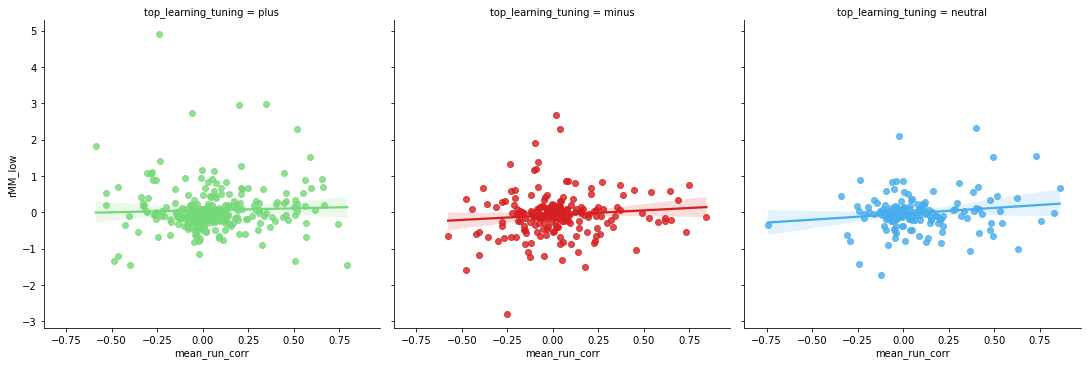

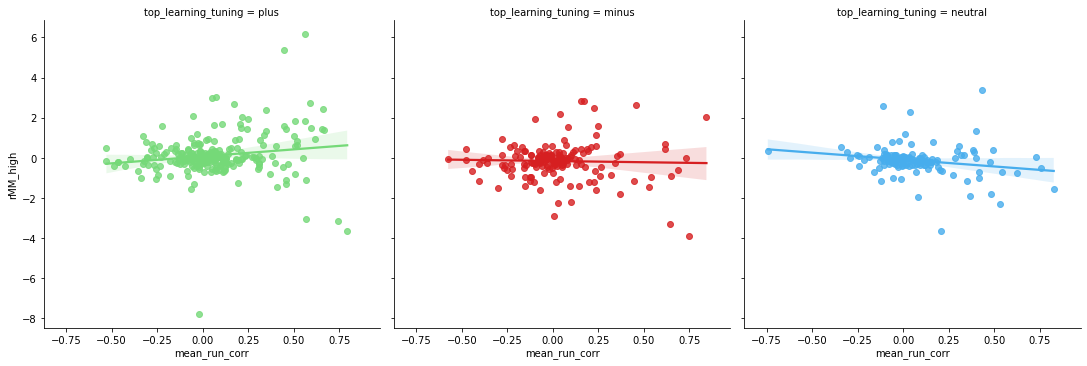

In [73]:
# Test 2
rmm_list_low, rmm_list_high = [], []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='low_pre_speed_only', filter_licking=None,
                                filter_hmm_engaged=False, force_same_day_reversal=False,
                                skew_stages_for_reversal=True, account_for_offset=False)
    rmm_list_low.append(rmml)
    rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='high_pre_speed_only', filter_licking=None,
                            filter_hmm_engaged=False, force_same_day_reversal=False,
                            skew_stages_for_reversal=True, account_for_offset=False)
    rmm_list_high.append(rmmh)
    
rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])
rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                    rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), run_df, cellt_df], axis=1)
all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
all_df.head()

plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none'])]
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_low', hue='top_learning_tuning', col='top_learning_tuning', palette=cas.lookups.color_dict)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/skew_low.png')
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='top_learning_tuning', col='top_learning_tuning', palette=cas.lookups.color_dict)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/skew_high.png')

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  }
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  )


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


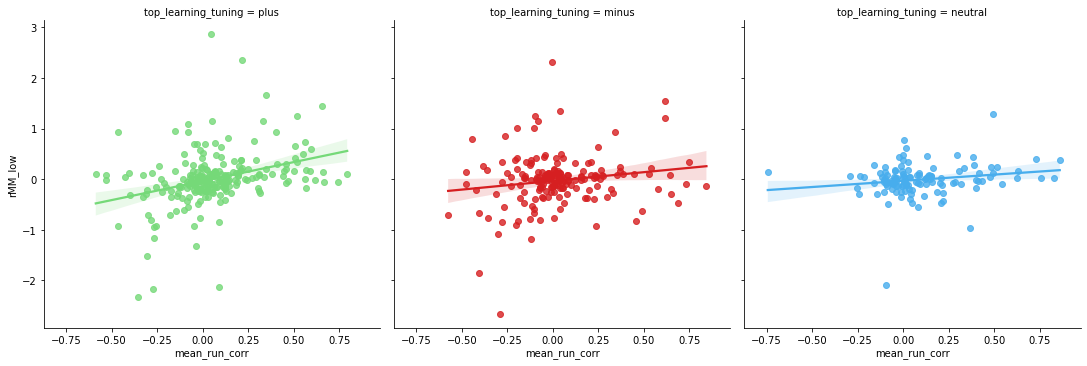

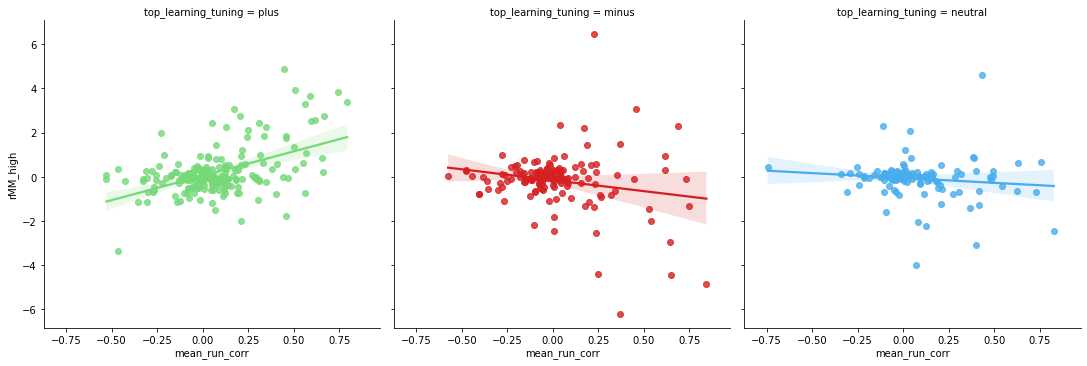

In [74]:
# Test 3
rmm_list_low, rmm_list_high = [], []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='low_speed_only', filter_licking=None,
                                filter_hmm_engaged=False, force_same_day_reversal=False,
                                use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_low.append(rmml)
    rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='high_speed_only', filter_licking=None,
                            filter_hmm_engaged=False, force_same_day_reversal=False,
                            use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_high.append(rmmh)
    
rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])
rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                    rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), run_df, cellt_df], axis=1)
all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
all_df.head()

plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none'])]
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_low', hue='top_learning_tuning', col='top_learning_tuning', palette=cas.lookups.color_dict)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/recap_low.png')
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='top_learning_tuning', col='top_learning_tuning', palette=cas.lookups.color_dict)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/recap_high.png')

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  }
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  )


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


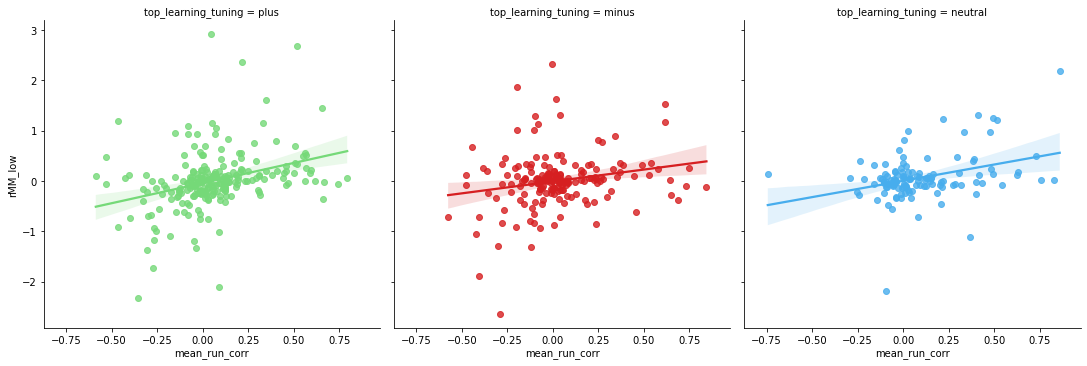

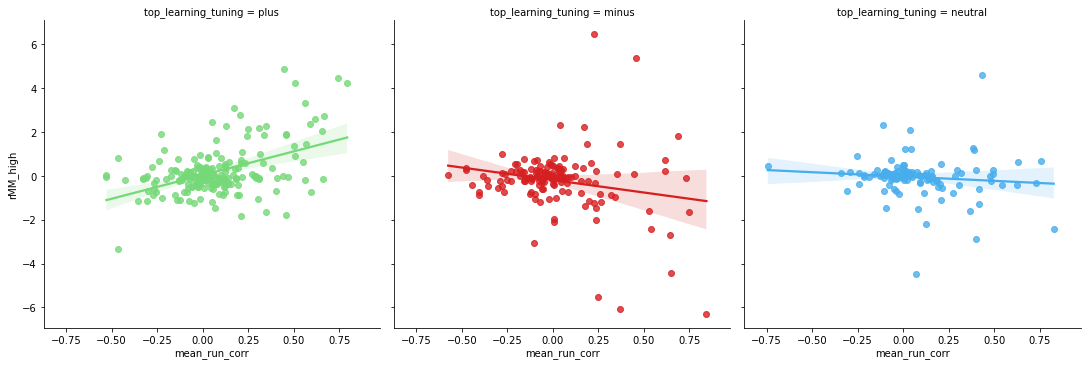

In [75]:
# Test 4
rmm_list_low, rmm_list_high = [], []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='low_speed_only', filter_licking=None,
                                filter_hmm_engaged=True, force_same_day_reversal=False,
                                use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_low.append(rmml)
    rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='high_speed_only', filter_licking=None,
                            filter_hmm_engaged=True, force_same_day_reversal=False,
                            use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_high.append(rmmh)
    
rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])
rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                    rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), run_df, cellt_df], axis=1)
all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
all_df.head()

plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none'])]
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_low', hue='top_learning_tuning', col='top_learning_tuning', palette=cas.lookups.color_dict)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/hmm_recap_low.png')
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='top_learning_tuning', col='top_learning_tuning', palette=cas.lookups.color_dict)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/hmm_recap_high.png')

In [77]:
mapping_mm = {}
for meta in meta_list:
    meta = cas.utils.add_reversal_mismatch_condition_to_meta(meta)
    pre_meta = meta.loc[meta.learning_state.isin(['learning'])]
    mouse = meta.reset_index().mouse.unique()[0]
    mapping_mm[mouse] = {}
    for cue in pre_meta.condition.unique():
        miscond = pre_meta.loc[pre_meta.condition.isin([cue]), 'mismatch_condition'].unique()[0]
        mapping_mm[mouse][cue] = miscond


{'AS20': {'plus': 'becomes_unrewarded',
  'neutral': 'becomes_rewarded',
  'minus': 'remains_unrewarded'},
 'AS23': {'neutral': 'becomes_rewarded',
  'minus': 'remains_unrewarded',
  'plus': 'becomes_unrewarded'},
 'AS41': {'minus': 'none', 'plus': 'none', 'neutral': 'none'},
 'AS47': {'neutral': 'none', 'plus': 'none', 'minus': 'none'},
 'OA26': {'plus': 'becomes_unrewarded',
  'neutral': 'remains_unrewarded',
  'minus': 'becomes_rewarded'},
 'OA27': {'plus': 'becomes_unrewarded',
  'minus': 'becomes_rewarded',
  'neutral': 'remains_unrewarded'},
 'OA32': {'plus': 'becomes_unrewarded',
  'minus': 'becomes_rewarded',
  'neutral': 'remains_unrewarded'},
 'OA34': {'minus': 'becomes_rewarded',
  'plus': 'becomes_unrewarded',
  'neutral': 'remains_unrewarded'},
 'OA36': {'minus': 'becomes_rewarded',
  'plus': 'becomes_unrewarded',
  'neutral': 'remains_unrewarded'},
 'OA38': {'neutral': 'none', 'minus': 'none', 'plus': 'none'},
 'OA67': {'plus': 'becomes_unrewarded',
  'neutral': 'remains_

## Grid search with baseline running corr

In [28]:
base_run_corr.reset_index().set_index(['mouse', 'cell_n']).sort_index().head()

cell_id parsed_11stage  baseline_running_correlation
mouse cell_n                                                      
AS20  1           525       L0 naive                           NaN
      1           525    L1 learning                      -0.02902
      1           525    L2 learning                      -0.02902
      1           525    L3 learning                      -0.02902
      1           525    L4 learning                           NaN

In [30]:
cellt_df.head()

learning_tuning reversal1_tuning
mouse cell_n                                 
AS20  1                 plus             plus
      2                 plus             plus
      3                 plus             none
      4                 plus             plus
      5                 plus             plus

In [31]:
remap_tune_col.head()

mm_tuning  cell_id
mouse cell_n                             
AS20  1       becomes_unrewarded      525
      2       becomes_unrewarded      164
      3       becomes_unrewarded      187
      4       becomes_unrewarded      118
      5       becomes_unrewarded      339

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablat

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


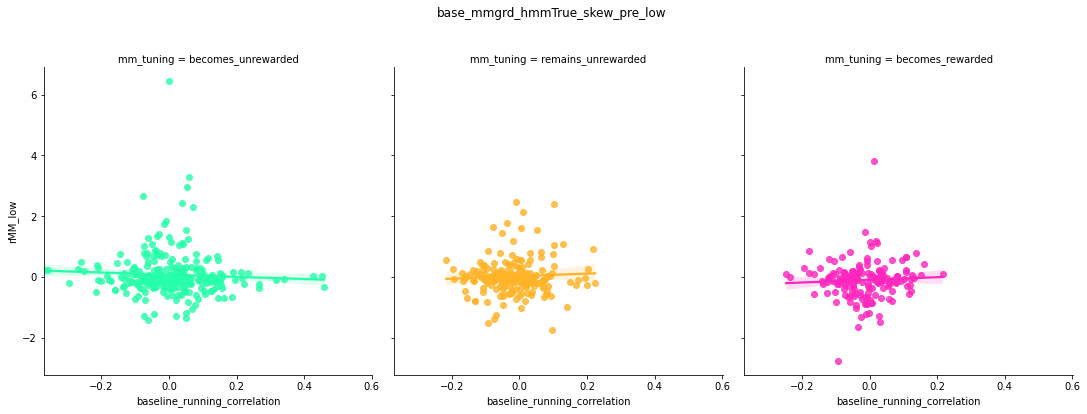

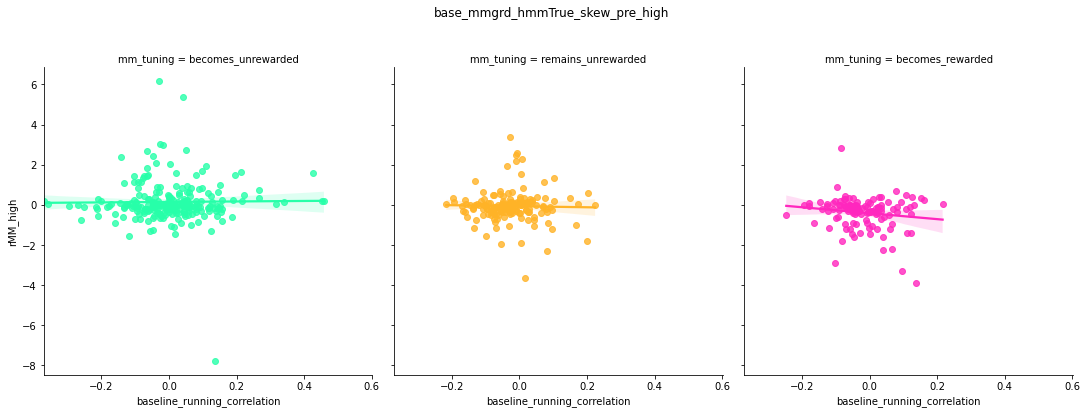

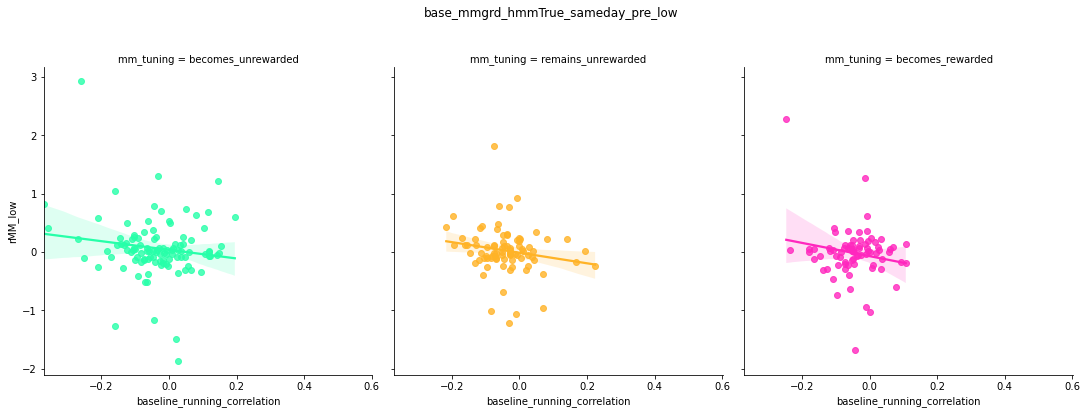

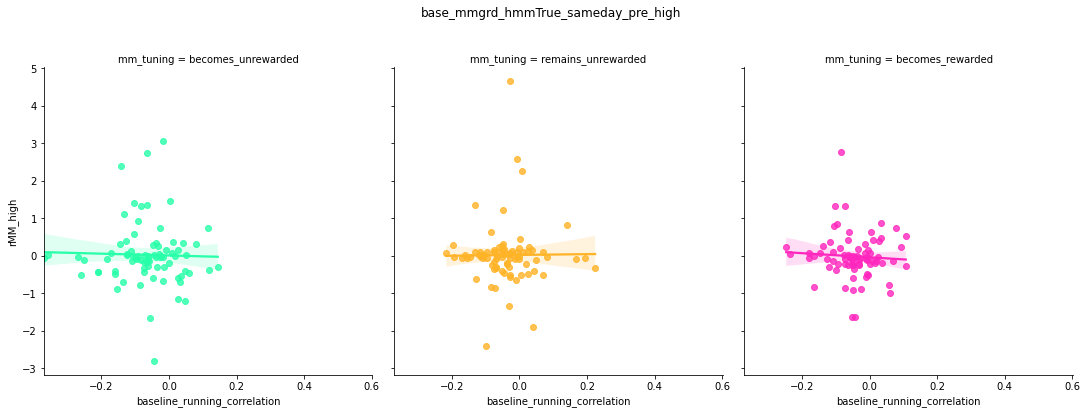

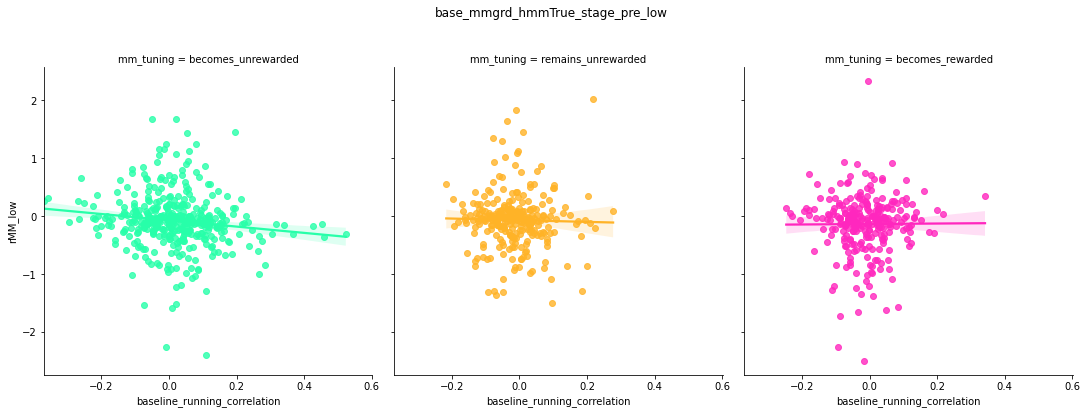

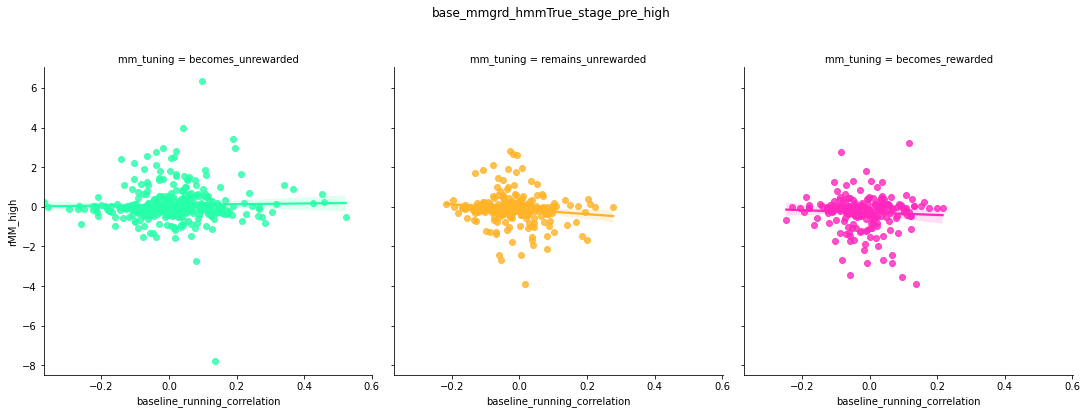

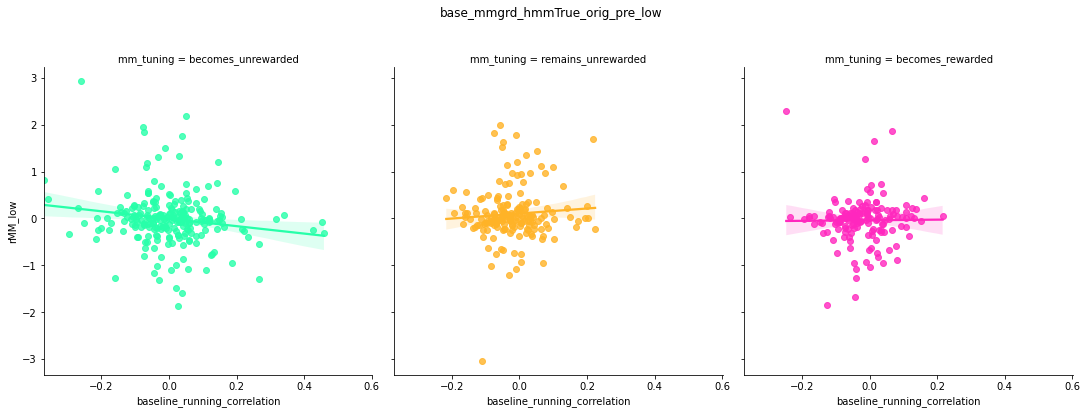

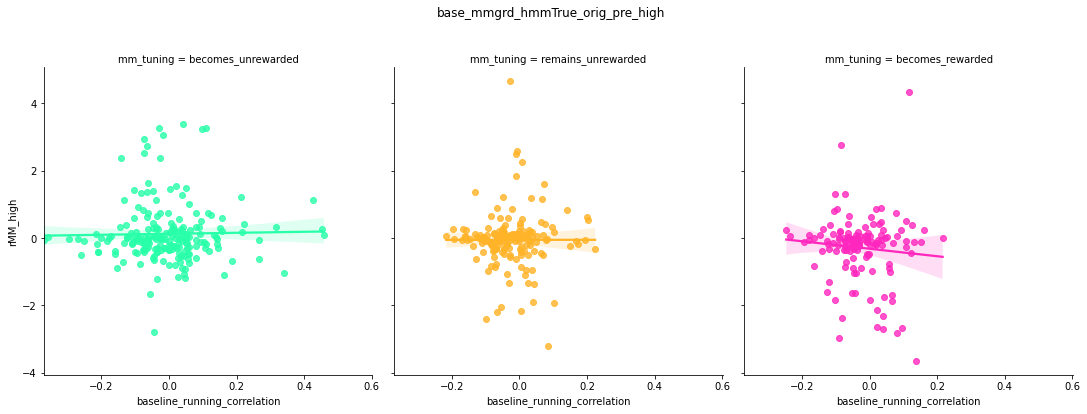

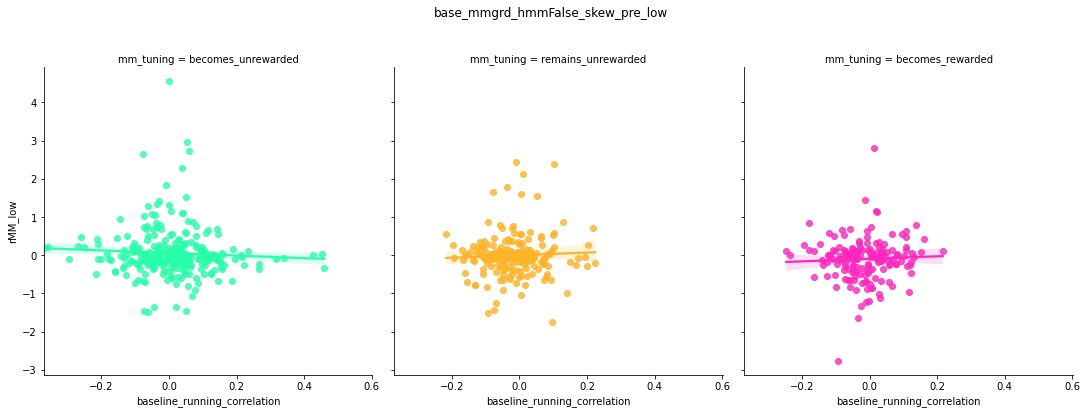

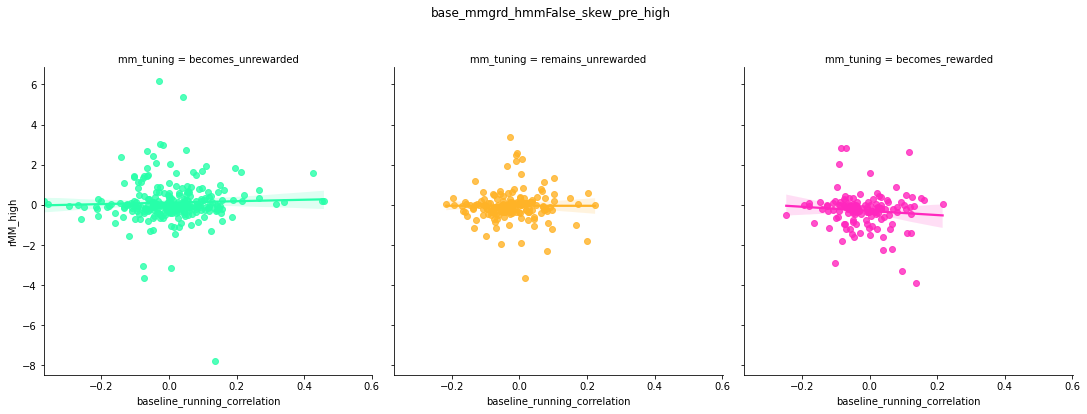

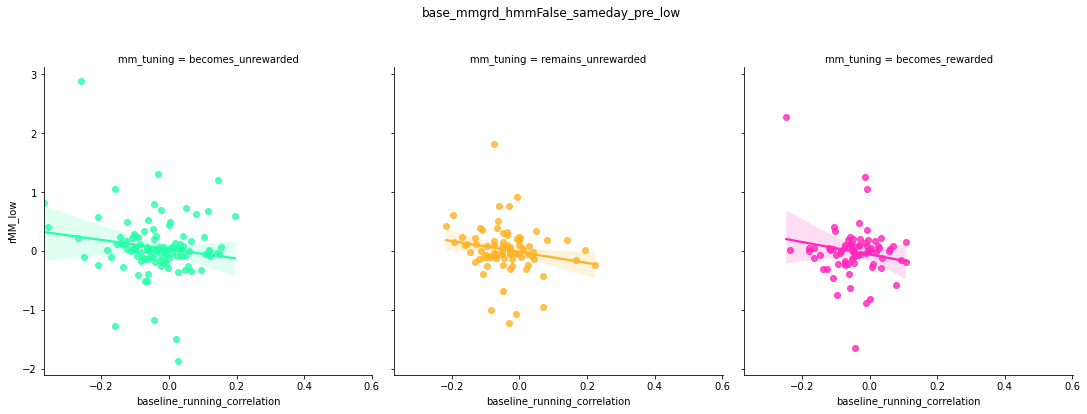

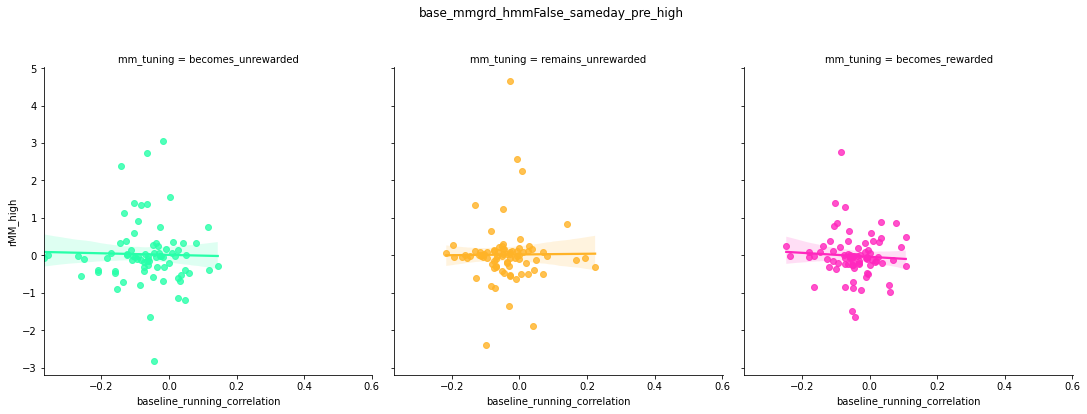

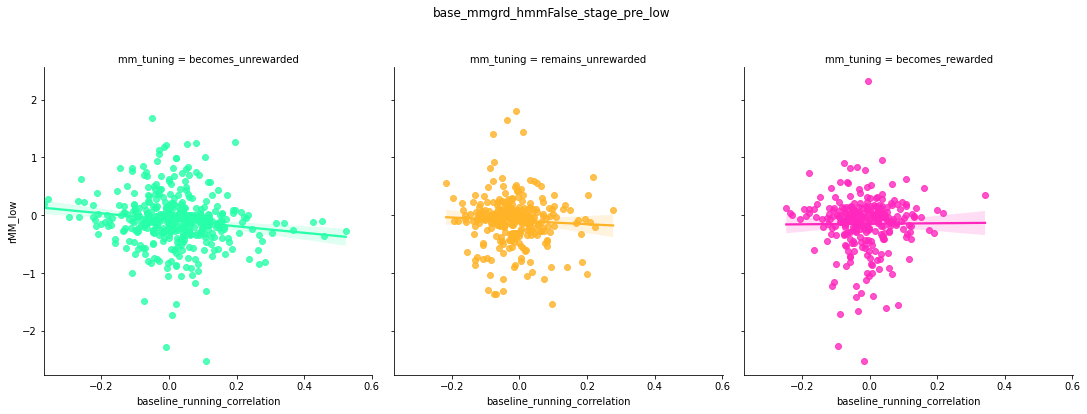

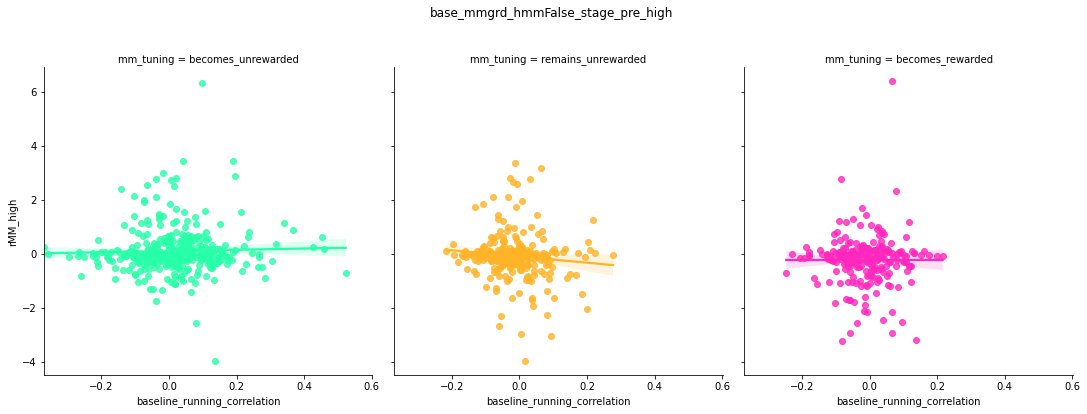

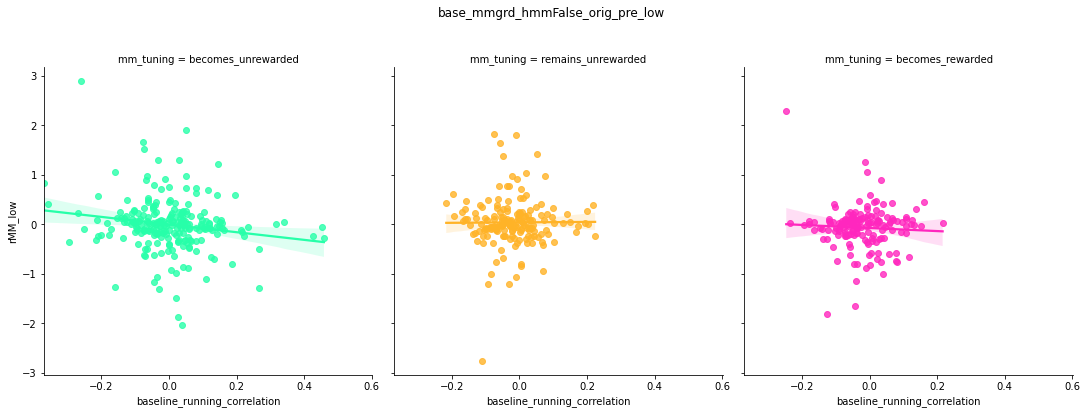

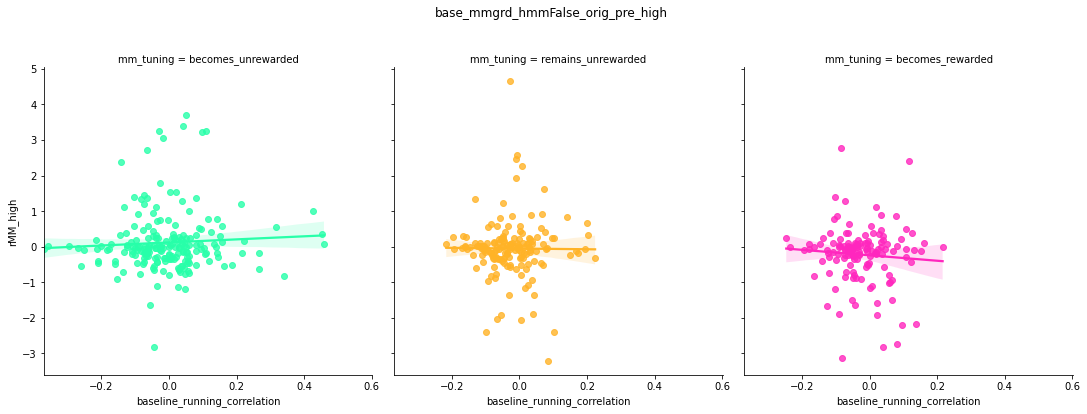

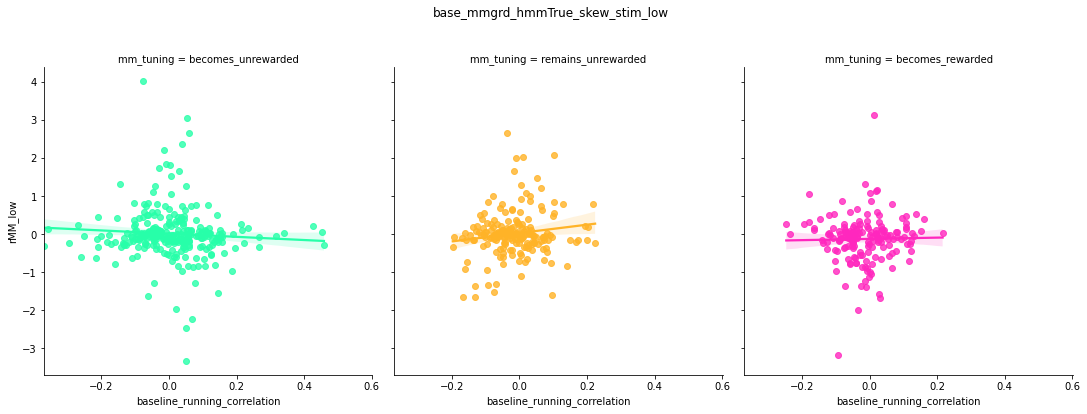

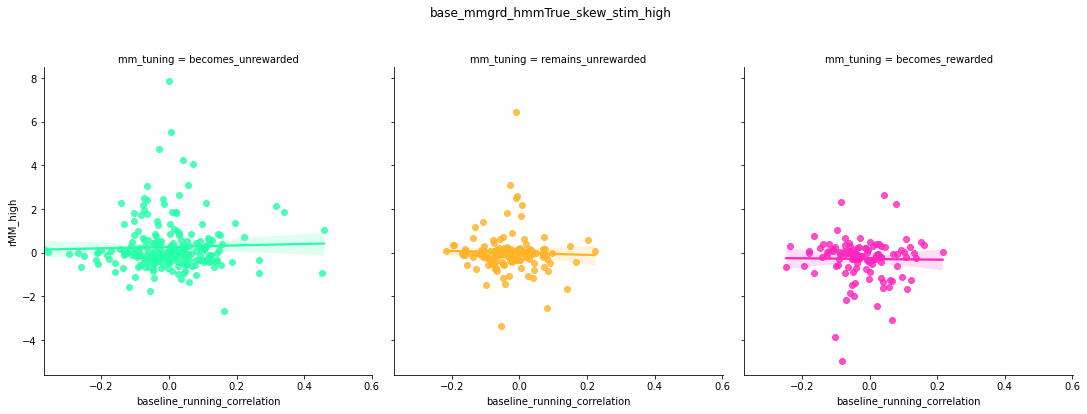

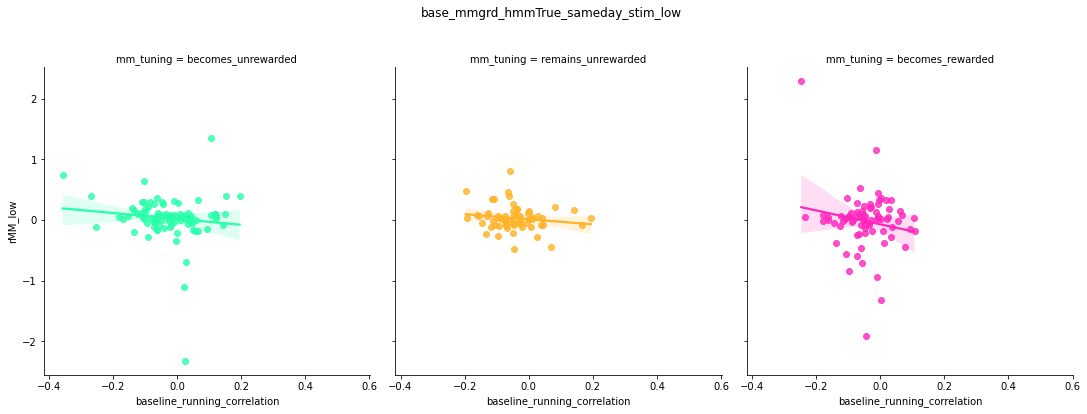

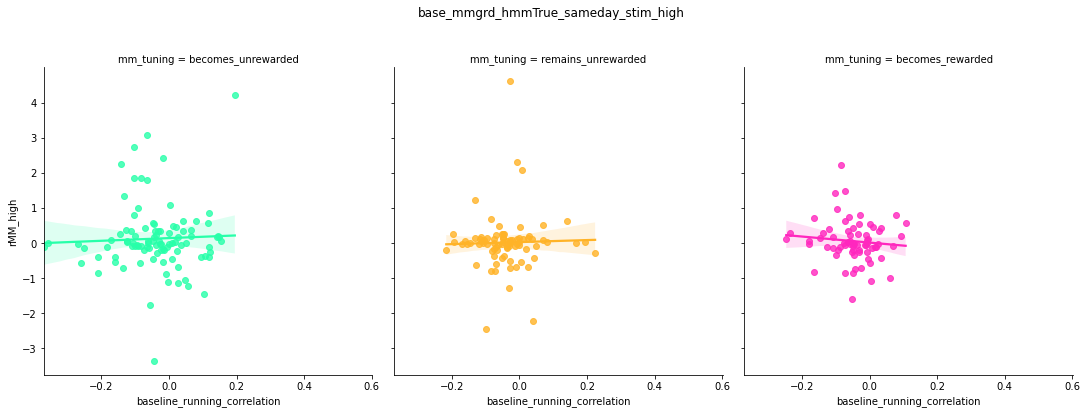

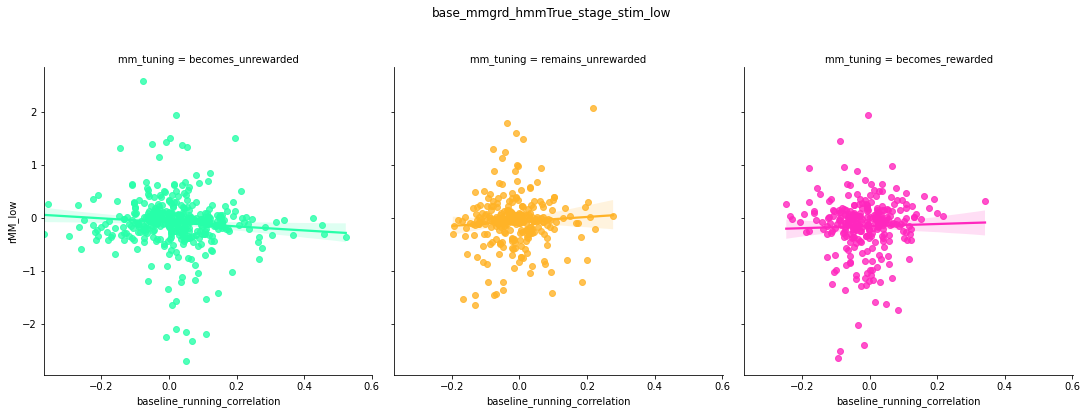

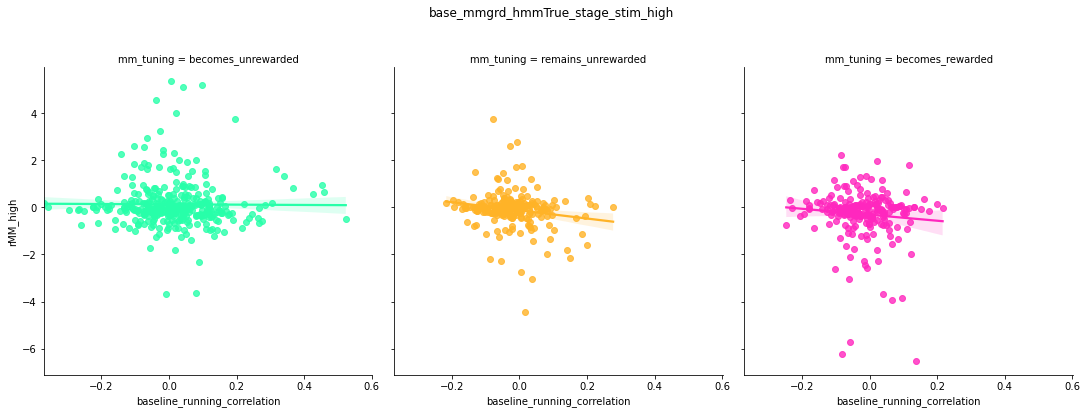

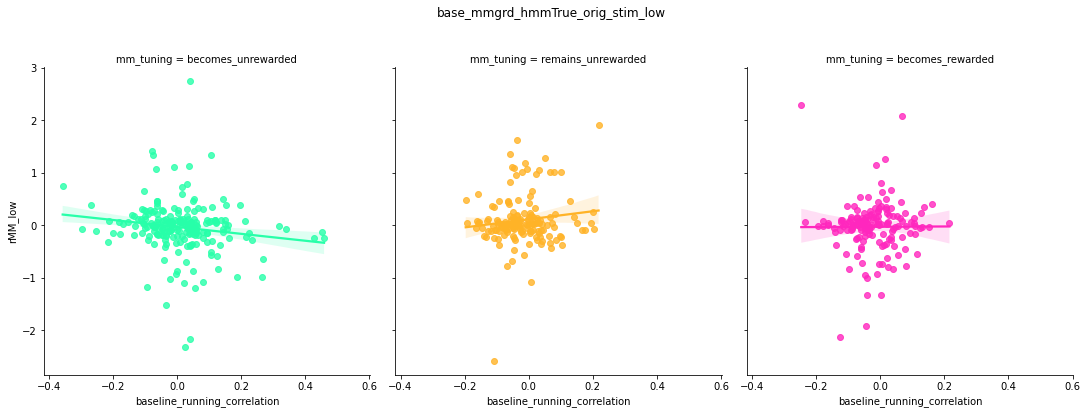

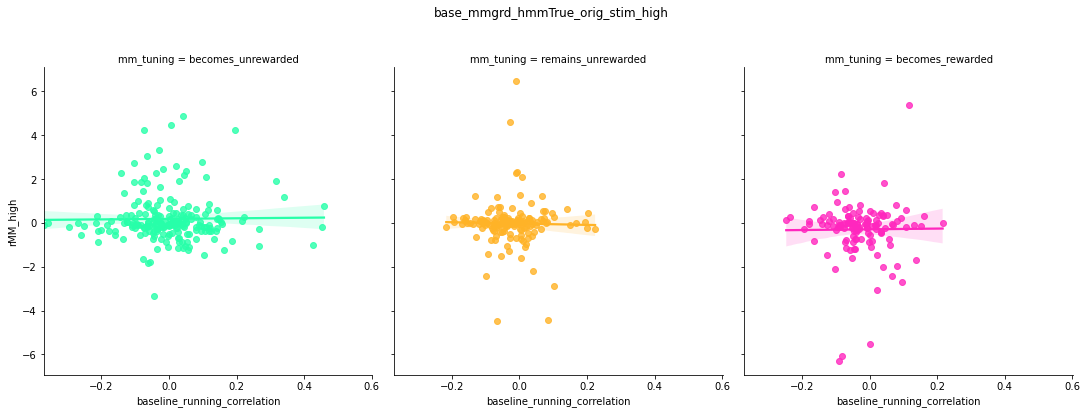

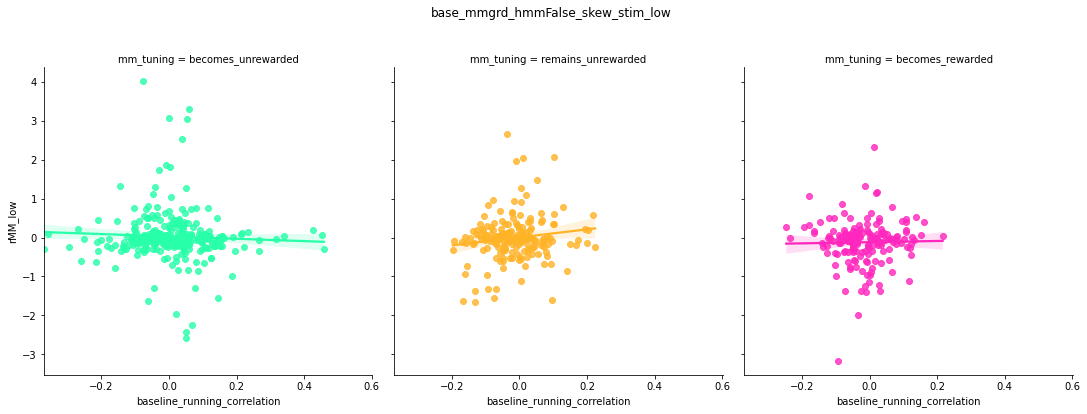

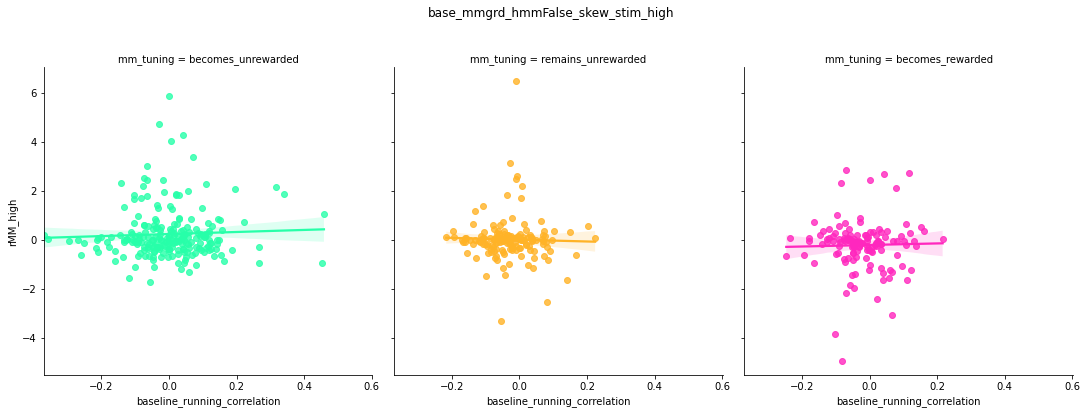

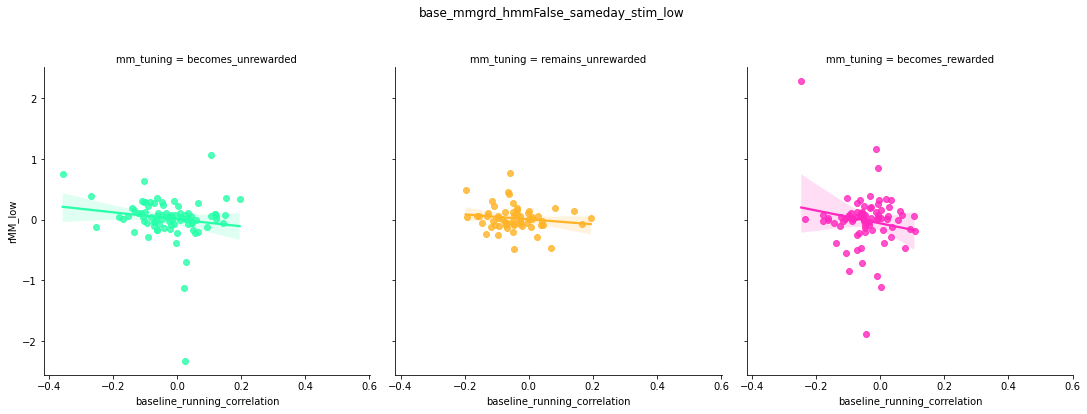

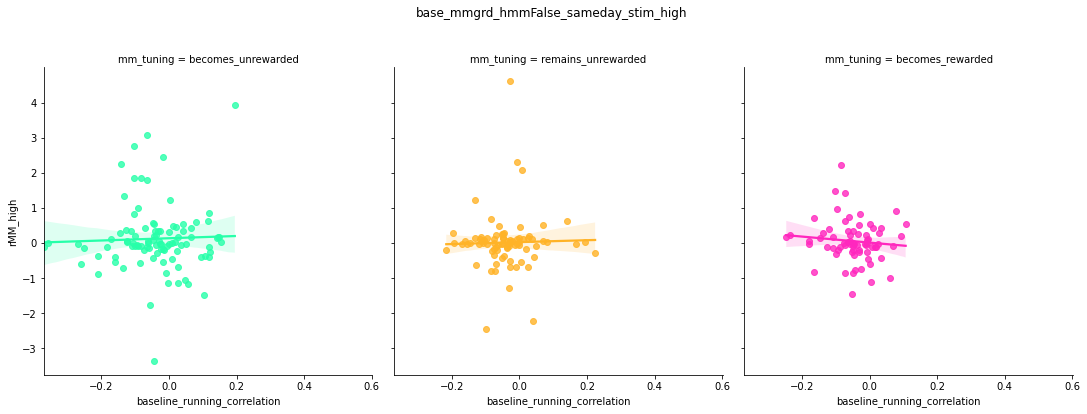

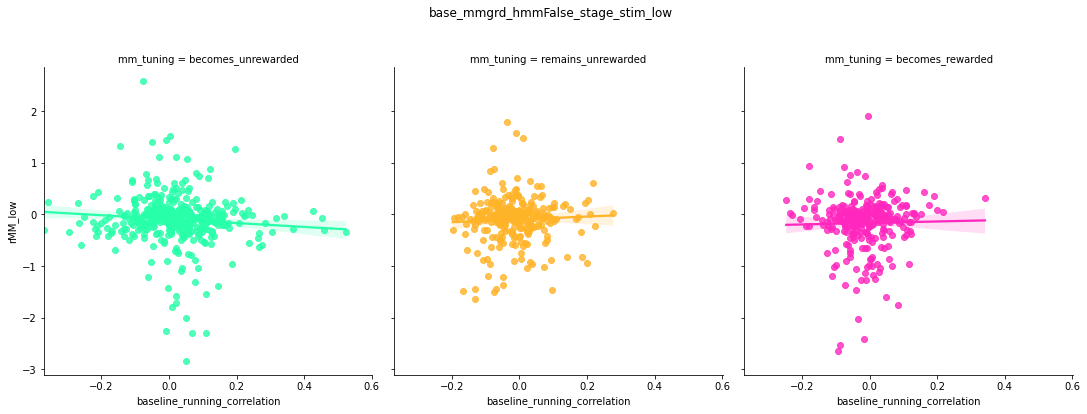

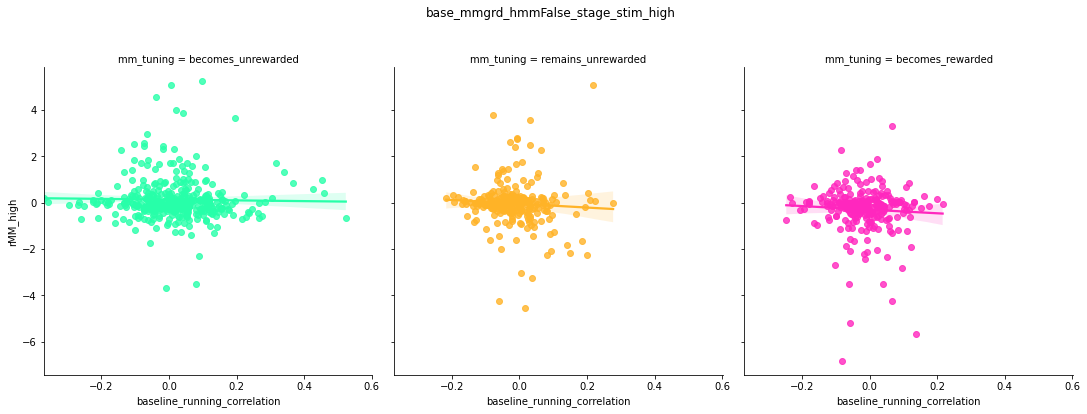

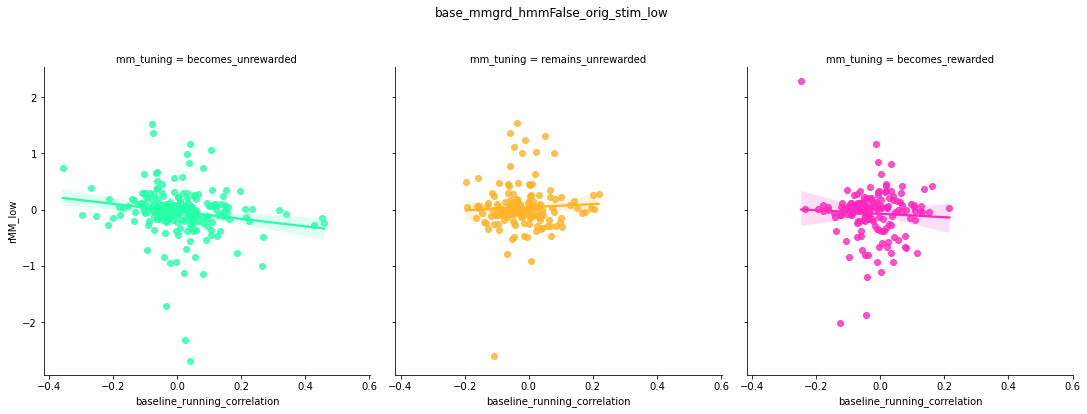

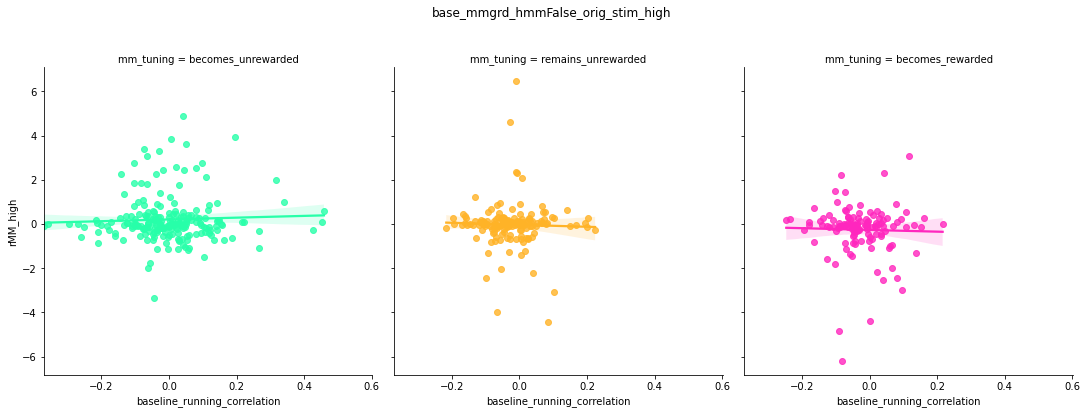

In [101]:
run_df2 = base_run_corr.reset_index().set_index(['mouse', 'cell_n']).sort_index().groupby(['mouse', 'cell_n']).mean()

# Grid search
for s in [['high_pre_speed_only', 'low_pre_speed_only'], ['high_speed_only', 'low_speed_only']]:
    for h in [True, False]:
        for ty in ['skew', 'sameday', 'stage', 'orig']:
            if ty == 'skew':
                t1, t2, t3 = False, True, False
            elif ty == 'sameday':
                t1, t2, t3 = True, False, False
            elif ty == 'stage':
                t1, t2, t3 = False, False, True
            elif ty == 'orig':
                t1, t2, t3 = False, False, False

            rmm_list_low, rmm_list_high = [], []
            for meta, pref_tensor in zip(meta_list, pref_tensor_list):
                rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running=s[1], filter_licking=None,
                                            filter_hmm_engaged=h, force_same_day_reversal=t1,
                                            skew_stages_for_reversal=t2, use_stages_for_reversal=t3, account_for_offset=False)
                rmm_list_low.append(rmml)
                rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running=s[0], filter_licking=None,
                                        filter_hmm_engaged=h, force_same_day_reversal=t1,
                                        skew_stages_for_reversal=t2, use_stages_for_reversal=t3, account_for_offset=False)
                rmm_list_high.append(rmmh)

            rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])

            rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

            all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                                rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), cellt_df, remap_tune_col], axis=1)
            all_df = all_df.join(run_df2.rename(columns={'cell_id': 'cell_id_gut_check'})) # join here to make sure index matches
            all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
            all_df.head()

            if s == ['high_pre_speed_only', 'low_pre_speed_only']:
                runtag = 'pre'
            else:
                runtag = 'stim'

            plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
            sns.lmplot(data=plot_df, x='baseline_running_correlation', y='rMM_low', hue='mm_tuning', col='mm_tuning',
                       palette=cas.lookups.color_dict)
            plt.suptitle(f'base_mmgrd_hmm{h}_{ty}_{runtag}_low', y=1.1)
            plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/base_mmgrd_hmm{h}_{ty}_{runtag}_low.png',
                        bbox_inches='tight', facecolor='white')

            sns.lmplot(data=plot_df, x='baseline_running_correlation', y='rMM_high', hue='mm_tuning', col='mm_tuning',
                       palette=cas.lookups.color_dict)
            plt.suptitle(f'base_mmgrd_hmm{h}_{ty}_{runtag}_high', y=1.1)
            plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/base_mmgrd_hmm{h}_{ty}_{runtag}_high.png',
                        bbox_inches='tight', facecolor='white')

## check for matched speed calc on running correlat

In [55]:
run_df.head()

cell_id  mean_run_corr  L5_run_corr  R5_run_corr
mouse cell_n                                                  
AS20  1           525       0.348010     0.320854     0.235171
      2           164       0.561076     0.174151     0.567942
      3           187       0.055618    -0.138632          NaN
      4           118       0.404083    -0.102070     0.240663
      5           339       0.188866    -0.220048     0.158799

In [56]:
rmm_list_low, rmm_list_high = [], []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmml = cas.mismatch.run_controlled_naive_mismatch(meta, pref_tensor, filter_running=None, filter_licking=None,
                                filter_hmm_engaged=True, account_for_offset=False)
    rmm_list_low.append(rmml)
#     rmmh = cas.mismatch.run_controlled_naive_mismatch(meta, pref_tensor, filter_running=None, filter_licking=None,
#                             filter_hmm_engaged=False, account_for_offset=False)
#     rmm_list_high.append(rmmh)

# rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])

rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

all_df = pd.concat([rmm_low_df, cellt_df, remap_tune_col], axis=1)
all_df = all_df.join(run_df.rename(columns={'cell_id': 'cell_id_gut_check'})) # join here to make sure index matches
all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
all_df.head()

  -->  AS20: pre-rev: 982, post-rev: 100


s:\twophoton_analysis\code\cascade\cascade\utils.py:1814: RuntimeWarning: Mean of empty slice
  binned_set1[:, bc] = np.nanmean(set1_tensor[:, bin_trials1], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:315: RuntimeWarning: Mean of empty slice
  reversal_mismatch = np.nanmean(post_bins - pre_bins, axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:331: RuntimeWarning: Mean of empty slice
  boot_mat[:, booti] = np.nanmean(post_bins - pre_bins, axis=1)


  -->  AS20: significant mismatch: n = 37
Mouse AS20 did not have L0 naive.
  -->  AS23: pre-rev: 1000, post-rev: 100
  -->  AS23: significant mismatch: n = 56
Mouse AS23 did not have L0 naive.
Mouse AS41 did not have any reversal.
Mouse AS41 did not have L0 naive.
Mouse AS47 did not have any reversal.
  -->  AS47: naive: 1000, learning-start: 97


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:376: RuntimeWarning: Mean of empty slice
  learn_mismatch = np.nanmean(post_learn_bins - pre_learn_bins, axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:392: RuntimeWarning: Mean of empty slice
  boot_mat[:, booti] = np.nanmean(post_bins - pre_bins, axis=1)


  -->  AS47: significant mismatch: n = 0
  -->  OA26: pre-rev: 1000, post-rev: 90
  -->  OA26: significant mismatch: n = 53
  -->  OA26: naive: 655, learning-start: 100
  -->  OA26: significant mismatch: n = 19
  -->  OA27: pre-rev: 711, post-rev: 100
  -->  OA27: significant mismatch: n = 86
  -->  OA27: naive: 414, learning-start: 81
  -->  OA27: significant mismatch: n = 17
  -->  OA32: pre-rev: 1000, post-rev: 100
  -->  OA32: significant mismatch: n = 59
Mouse OA32 did not have L0 naive.
  -->  OA34: pre-rev: 801, post-rev: 34
  -->  OA34: significant mismatch: n = 61
Mouse OA34 did not have L0 naive.
  -->  OA36: pre-rev: 994, post-rev: 21
  -->  OA36: significant mismatch: n = 31
Mouse OA36 did not have L0 naive.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have L0 naive.
  -->  OA67: pre-rev: 985, post-rev: 100
  -->  OA67: significant mismatch: n = 51
  -->  OA67: naive: 487, learning-start: 9
  -->  OA67: significant mismatch: n = 25
  -->  VF226: pre-rev: 986, po

lMM_response  lMM_pvals  rMM_response  rMM_pvals  \
mouse cell_n                                                     
AS20  1                NaN        NaN      2.106711      0.005   
      2                NaN        NaN           NaN        NaN   
      3                NaN        NaN           NaN        NaN   
      4                NaN        NaN      0.886870      0.002   
      5                NaN        NaN      0.431706      0.046   

             learning_tuning reversal1_tuning           mm_tuning  cell_id  \
mouse cell_n                                                                 
AS20  1                 plus             plus  becomes_unrewarded      525   
      2                 plus             plus  becomes_unrewarded      164   
      3                 plus             none  becomes_unrewarded      187   
      4                 plus             plus  becomes_unrewarded      118   
      5                 plus             plus  becomes_unrewarded      339   

              cell_id_gut_check  mean_run_corr  L5_run_corr  R5_run_corr  \
mouse cell_n                                                               
AS20  1                     525       0.348010     0.320854     0.235171   
      2                     164       0.561076     0.174151     0.567942   
      3                     187       0.055618    -0.138632          NaN   
      4                     118       0.404083    -0.102070     0.240663   
      5                     339       0.188866    -0.220048     0.158799   

             top_learning_tuning  
mouse cell_n                      
AS20  1                     plus  
      2                     plus  
      3                     plus  
      4                     plus  
      5                     plus

Text(0.5, 1.1, 'stim_running_corr vs matched running')

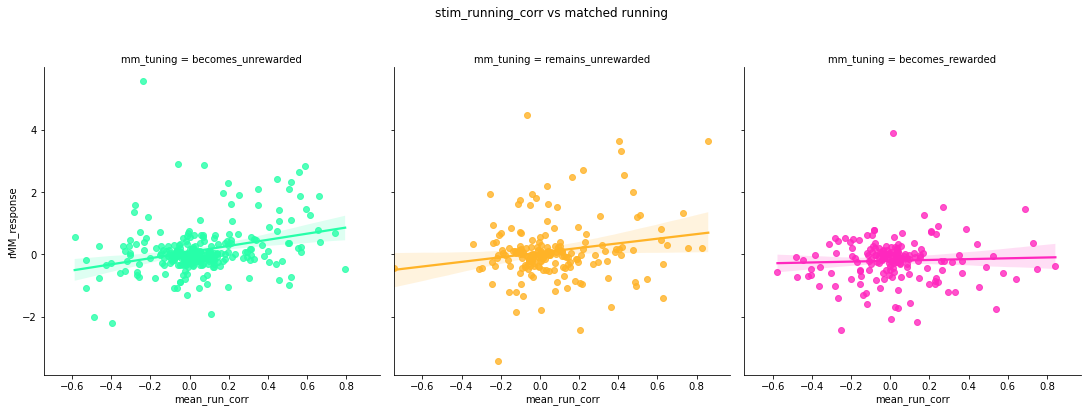

In [57]:
plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_response', hue='mm_tuning', col='mm_tuning',
           palette=cas.lookups.color_dict)
plt.suptitle(f'stim_running_corr vs matched running', y=1.1)
# plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/stim_running_corr_hmmTrue_matched_running.png',
#             bbox_inches='tight', facecolor='white')

In [65]:
from scipy.stats import pearsonr 

mm = 'becomes_unrewarded'
for mm in plot_df.mm_tuning.unique():
    cleaned_df = plot_df.loc[plot_df.mm_tuning.isin([mm]), ['mean_run_corr', 'rMM_response']].dropna()
    # cleaned_df.head()
    print(mm, pearsonr(cleaned_df.mean_run_corr, cleaned_df.rMM_response))

becomes_unrewarded (0.29783227808953205, 7.168955070374868e-07)
remains_unrewarded (0.18225648648369608, 0.011620224213155353)
becomes_rewarded (0.04442585576481727, 0.5651203343792847)


In [64]:
pearsonr(cleaned_df.mean_run_corr, cleaned_df.rMM_response)

(0.29783227808953205, 7.168955070374868e-07)

In [75]:
plot_df.join(offvec_df.drop(columns=['cell_id'])).head()

lMM_response  lMM_pvals  rMM_response  rMM_pvals  \
mouse cell_n                                                     
AS20  1                NaN        NaN      2.106711      0.005   
      1                NaN        NaN      2.106711      0.005   
      1                NaN        NaN      2.106711      0.005   
      1                NaN        NaN      2.106711      0.005   
      1                NaN        NaN      2.106711      0.005   

             learning_tuning reversal1_tuning           mm_tuning  cell_id  \
mouse cell_n                                                                 
AS20  1                 plus             plus  becomes_unrewarded      525   
      1                 plus             plus  becomes_unrewarded      525   
      1                 plus             plus  becomes_unrewarded      525   
      1                 plus             plus  becomes_unrewarded      525   
      1                 plus             plus  becomes_unrewarded      525   

              cell_id_gut_check  mean_run_corr  L5_run_corr  R5_run_corr  \
mouse cell_n                                                               
AS20  1                     525        0.34801     0.320854     0.235171   
      1                     525        0.34801     0.320854     0.235171   
      1                     525        0.34801     0.320854     0.235171   
      1                     525        0.34801     0.320854     0.235171   
      1                     525        0.34801     0.320854     0.235171   

             top_learning_tuning  offset_cell  
mouse cell_n                                   
AS20  1                     plus        False  
      1                     plus        False  
      1                     plus        False  
      1                     plus        False  
      1                     plus        False

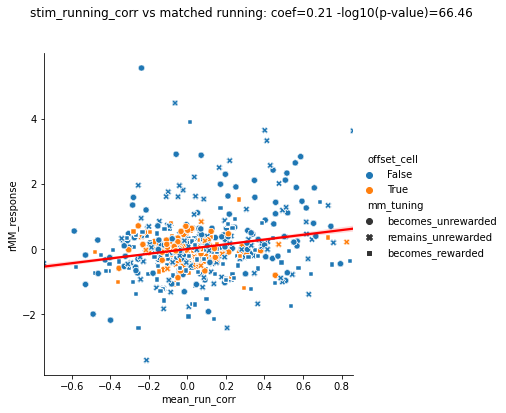

In [93]:
plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
plot_df = plot_df.join(offvec_df.drop(columns=['cell_id']))
# g = sns.regplot(data=plot_df, x='mean_run_corr', y='rMM_response', scatter=False)
sns.relplot(data=plot_df, x='mean_run_corr', y='rMM_response', hue='offset_cell', style='mm_tuning', )
sns.regplot(data=plot_df, x='mean_run_corr', y='rMM_response', scatter=False, color='red')
# sns.regplot(data=plot_df.loc[plot_df.offset_cell], x='mean_run_corr', y='rMM_response', scatter=False, color='orange')
# sns.regplot(data=plot_df.loc[~plot_df.offset_cell], x='mean_run_corr', y='rMM_response', scatter=False, color='blue')
#            palette=cas.lookups.color_dict)

cleaned_df = plot_df.loc[:, ['mean_run_corr', 'rMM_response']].dropna()
rv, pv = pearsonr(cleaned_df.mean_run_corr, cleaned_df.rMM_response)

plt.suptitle(f'stim_running_corr vs matched running: coef={round(rv,2)} -log10(p-value)={round(-1*np.log10(pv), 2)}', y=1.1)
plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/stim_running_corr_alltogether_v1.png',
            bbox_inches='tight', facecolor='white')

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)


Mouse AS20 did not have single-day reversal.
Mouse AS20 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS23 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS41 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.
Mouse AS47 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse OA32 did not have single-day reversal.
Mouse OA32 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA34 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA36 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.
Mouse OA38 did not have single-day reversal.


s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev]

Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


<Figure size 432x288 with 0 Axes>

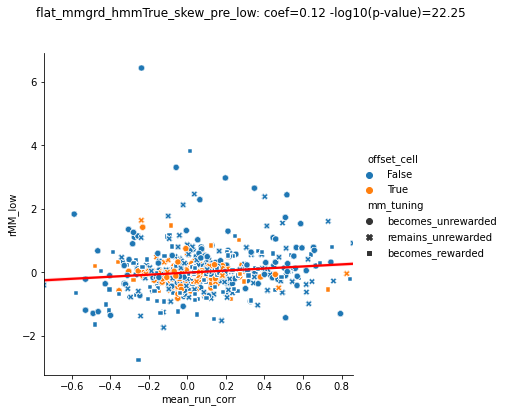

<Figure size 432x288 with 0 Axes>

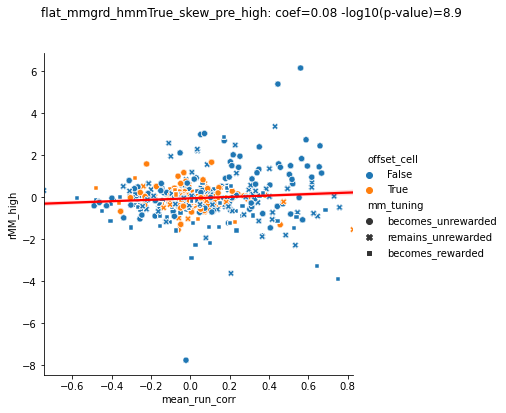

<Figure size 432x288 with 0 Axes>

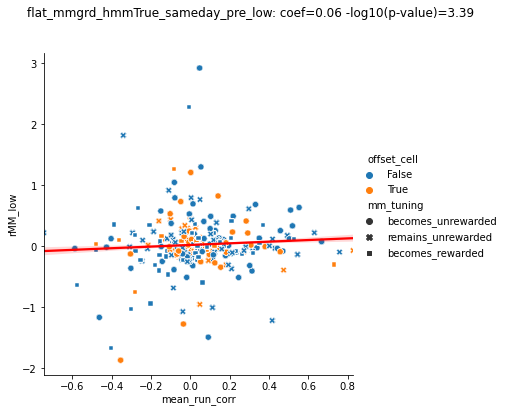

<Figure size 432x288 with 0 Axes>

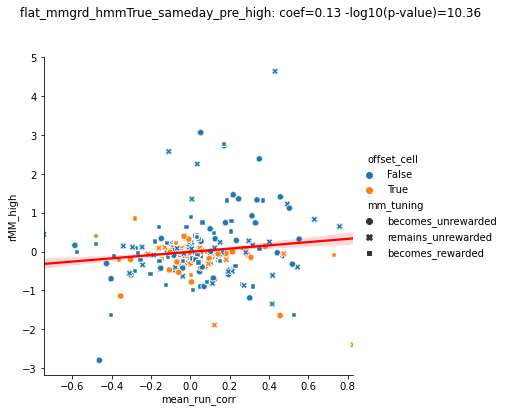

<Figure size 432x288 with 0 Axes>

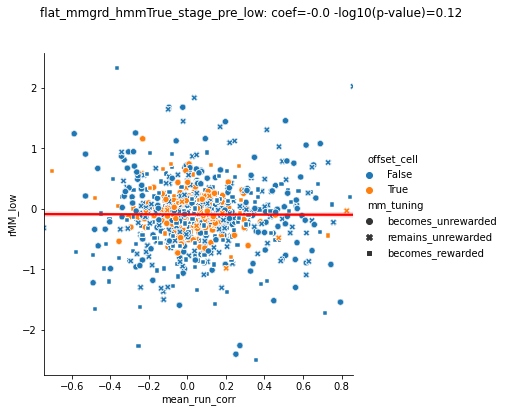

<Figure size 432x288 with 0 Axes>

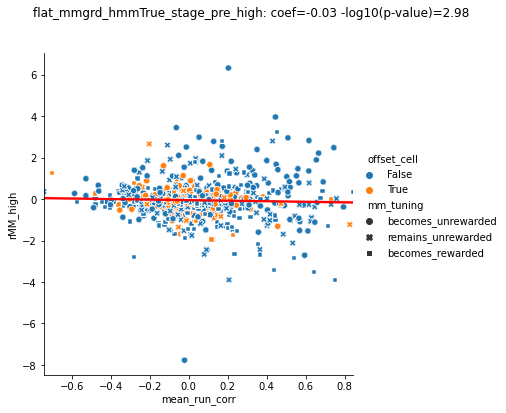

<Figure size 432x288 with 0 Axes>

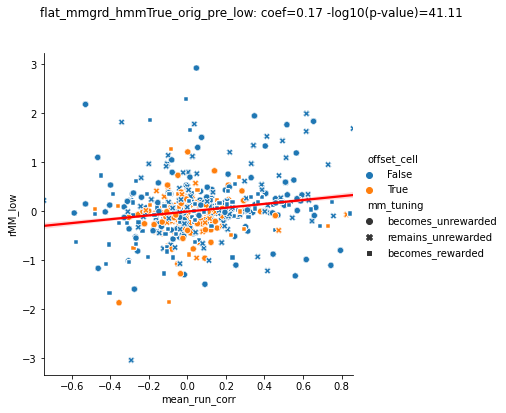

<Figure size 432x288 with 0 Axes>

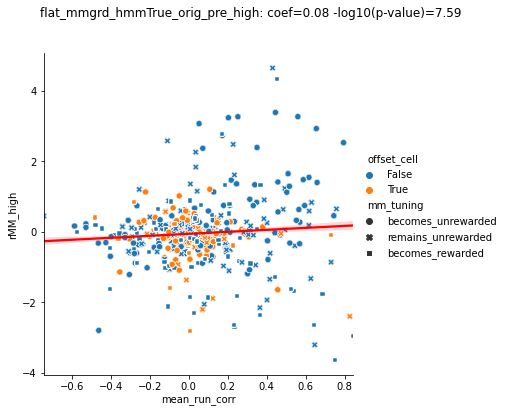

<Figure size 432x288 with 0 Axes>

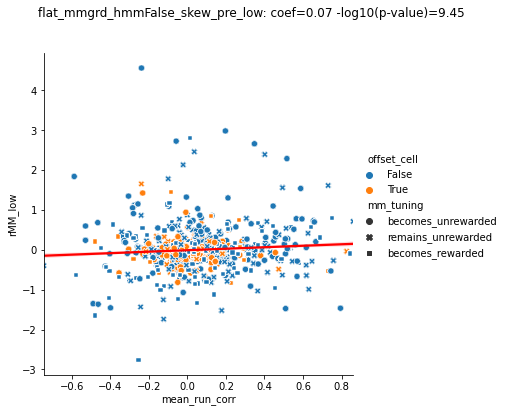

<Figure size 432x288 with 0 Axes>

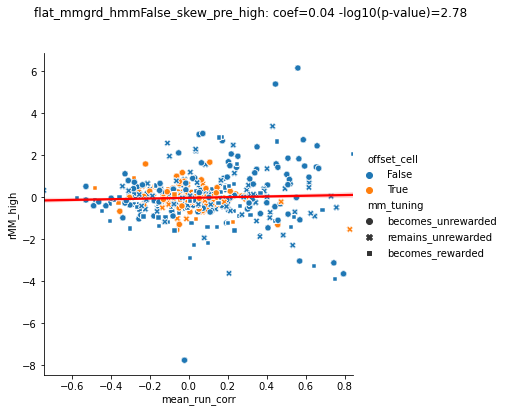

<Figure size 432x288 with 0 Axes>

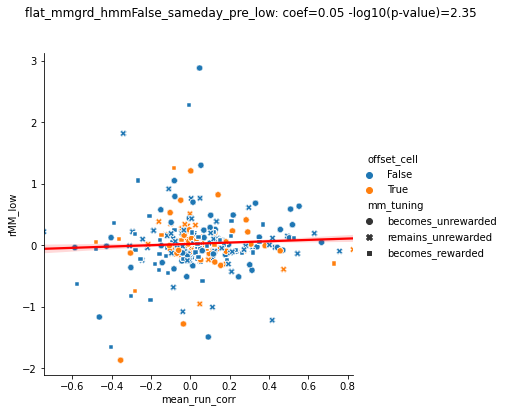

<Figure size 432x288 with 0 Axes>

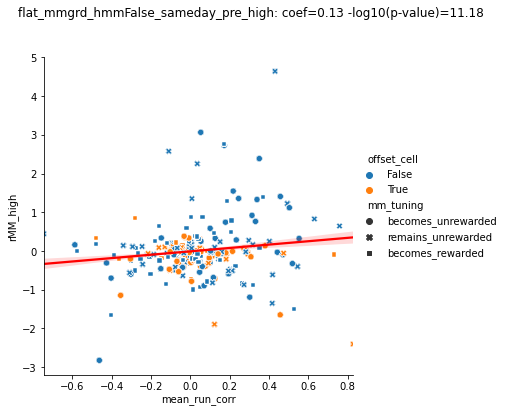

<Figure size 432x288 with 0 Axes>

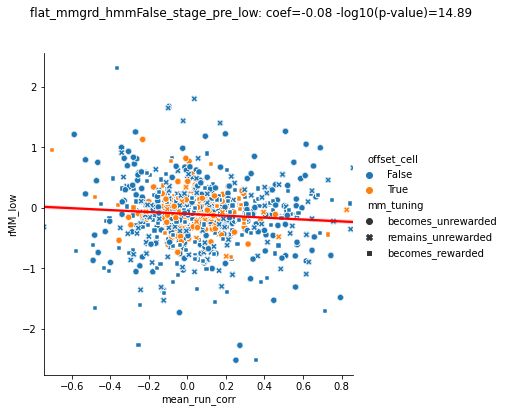

<Figure size 432x288 with 0 Axes>

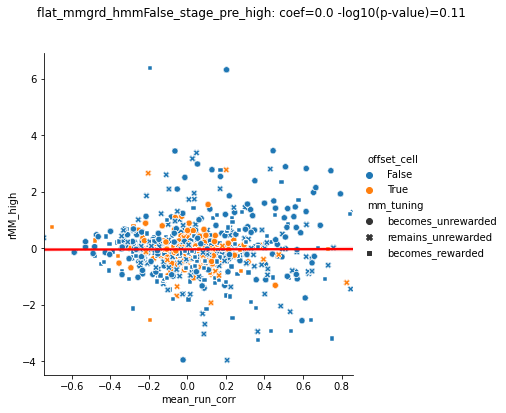

<Figure size 432x288 with 0 Axes>

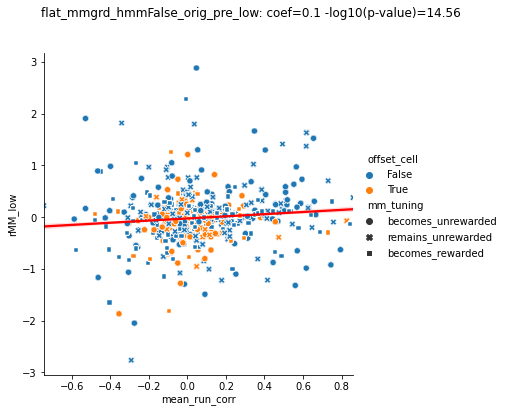

<Figure size 432x288 with 0 Axes>

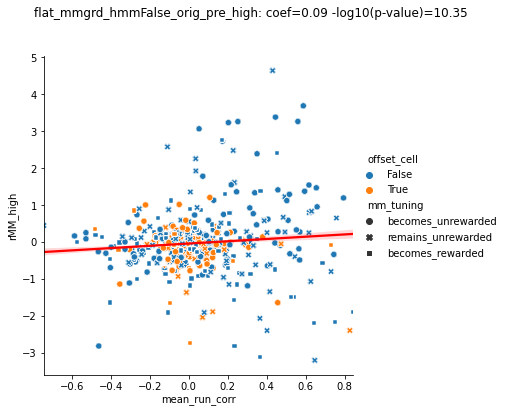

<Figure size 432x288 with 0 Axes>

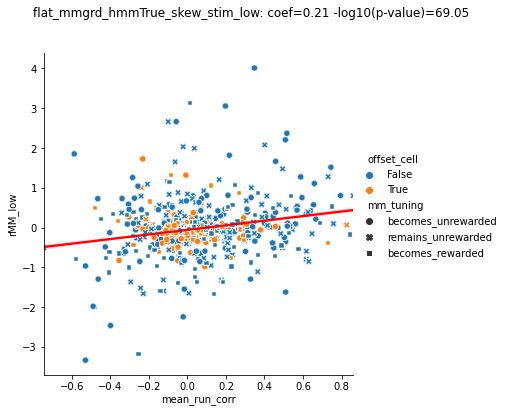

<Figure size 432x288 with 0 Axes>

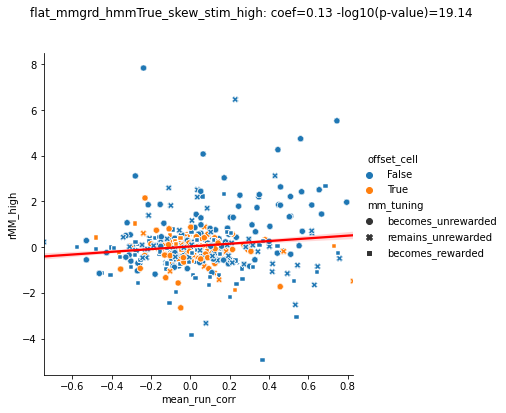

<Figure size 432x288 with 0 Axes>

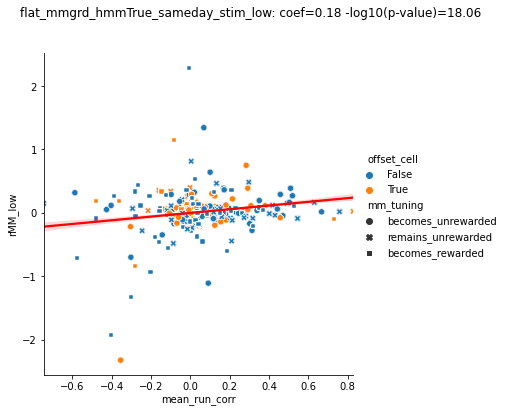

<Figure size 432x288 with 0 Axes>

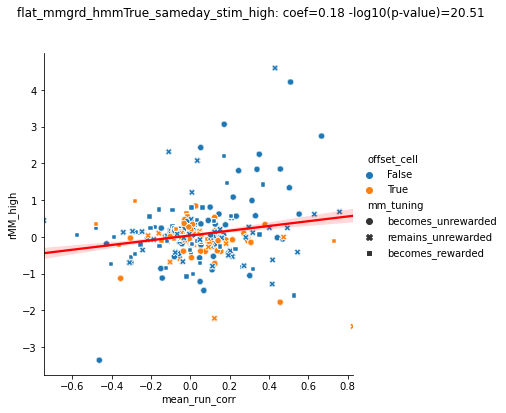

<Figure size 432x288 with 0 Axes>

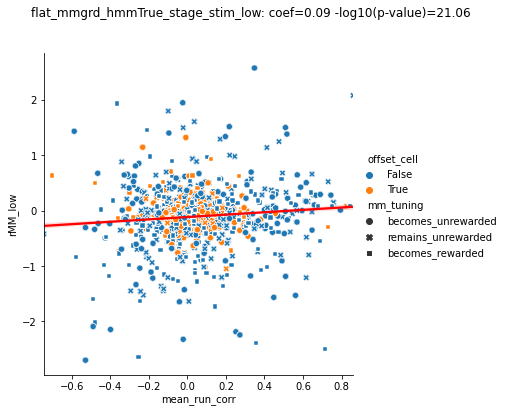

<Figure size 432x288 with 0 Axes>

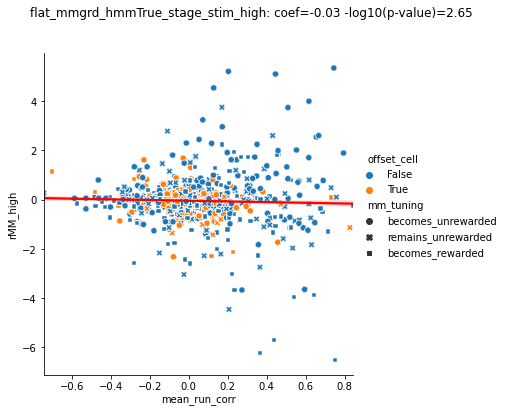

<Figure size 432x288 with 0 Axes>

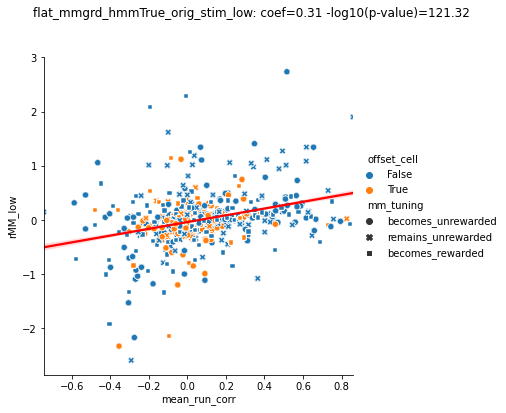

<Figure size 432x288 with 0 Axes>

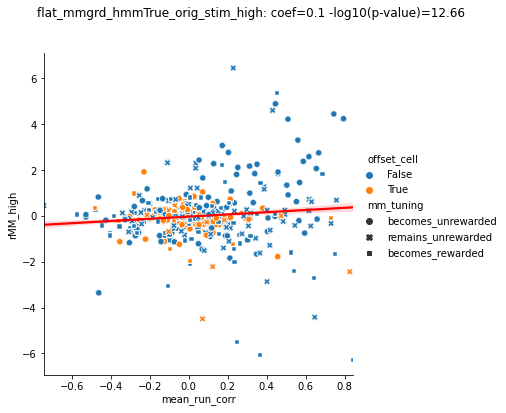

<Figure size 432x288 with 0 Axes>

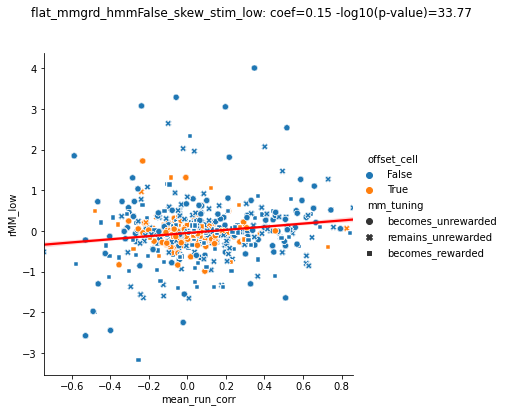

<Figure size 432x288 with 0 Axes>

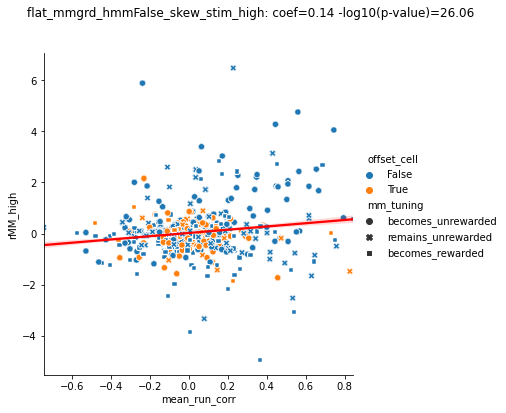

<Figure size 432x288 with 0 Axes>

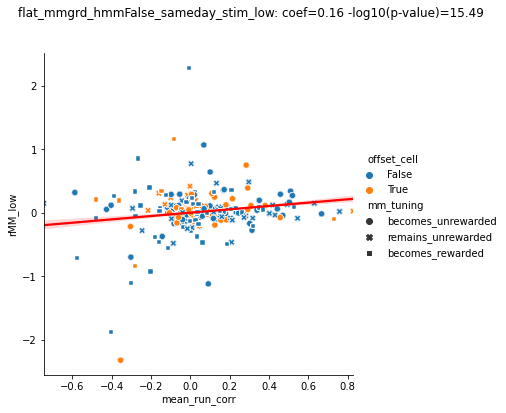

<Figure size 432x288 with 0 Axes>

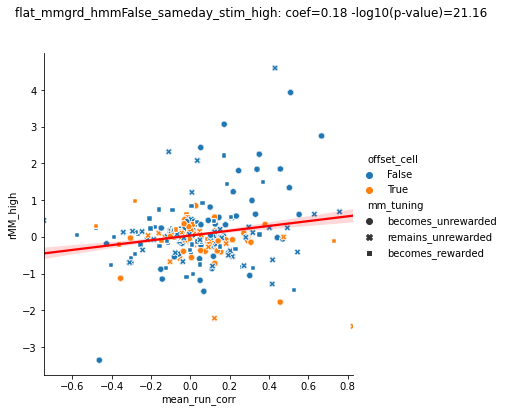

<Figure size 432x288 with 0 Axes>

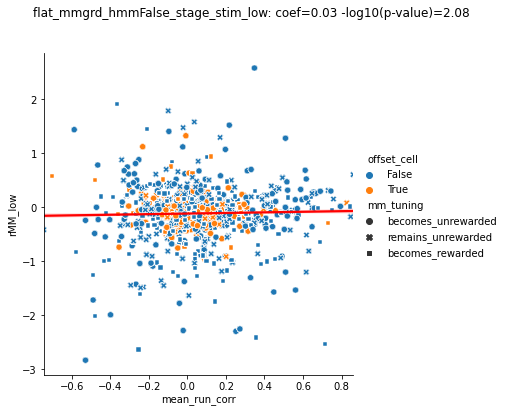

<Figure size 432x288 with 0 Axes>

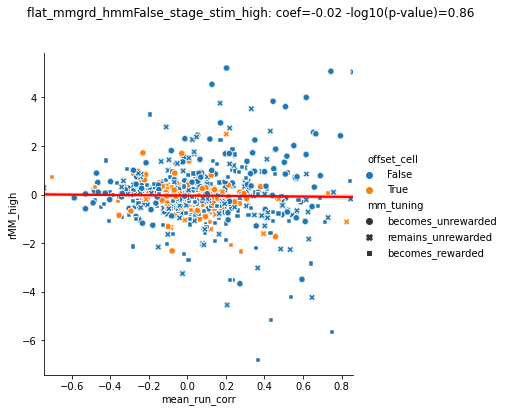

<Figure size 432x288 with 0 Axes>

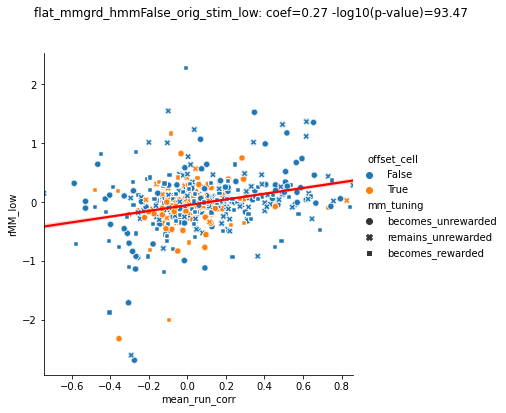

<Figure size 432x288 with 0 Axes>

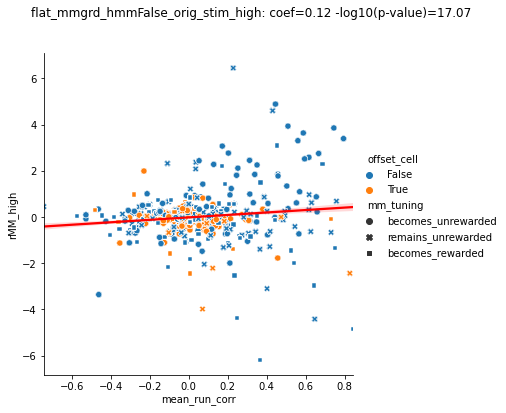

In [100]:
# Grid search
for s in [['high_pre_speed_only', 'low_pre_speed_only'], ['high_speed_only', 'low_speed_only']]:
    for h in [True, False]:
        for ty in ['skew', 'sameday', 'stage', 'orig']:
            if ty == 'skew':
                t1, t2, t3 = False, True, False
            elif ty == 'sameday':
                t1, t2, t3 = True, False, False
            elif ty == 'stage':
                t1, t2, t3 = False, False, True
            elif ty == 'orig':
                t1, t2, t3 = False, False, False

            rmm_list_low, rmm_list_high = [], []
            for meta, pref_tensor in zip(meta_list, pref_tensor_list):
                rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running=s[1], filter_licking=None,
                                            filter_hmm_engaged=h, force_same_day_reversal=t1,
                                            skew_stages_for_reversal=t2, use_stages_for_reversal=t3, account_for_offset=False)
                rmm_list_low.append(rmml)
                rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running=s[0], filter_licking=None,
                                        filter_hmm_engaged=h, force_same_day_reversal=t1,
                                        skew_stages_for_reversal=t2, use_stages_for_reversal=t3, account_for_offset=False)
                rmm_list_high.append(rmmh)

            rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])

            rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

            all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                                rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), cellt_df, remap_tune_col], axis=1)
            all_df = all_df.join(run_df.drop(columns=['cell_id']))
#             all_df = all_df.join(offvec_df.drop(columns=['cell_id']))
            all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
            all_df.head()

            if s == ['high_pre_speed_only', 'low_pre_speed_only']:
                runtag = 'pre'
            else:
                runtag = 'stim'
            
            plt.figure()
            plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
            plot_df = plot_df.join(offvec_df.drop(columns=['cell_id']))
            sns.relplot(data=plot_df, x='mean_run_corr', y='rMM_low', hue='offset_cell', style='mm_tuning', )
            sns.regplot(data=plot_df, x='mean_run_corr', y='rMM_low', scatter=False, color='red')
            cleaned_df = plot_df.loc[:, ['mean_run_corr', 'rMM_low']].dropna()
            rv, pv = pearsonr(cleaned_df.mean_run_corr, cleaned_df.rMM_low)
            plt.suptitle(f'flat_mmgrd_hmm{h}_{ty}_{runtag}_low: coef={round(rv,2)} -log10(p-value)={round(-1*np.log10(pv), 2)}', y=1.1)
            plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/flat_mmgrd_hmm{h}_{ty}_{runtag}_low.png',
                        bbox_inches='tight', facecolor='white')
            
            plt.figure()
            plot_df = all_df.loc[~all_df.top_learning_tuning.isin(['broad', 'none']) & ~all_df.mm_tuning.isin(['none'])]
            plot_df = plot_df.join(offvec_df.drop(columns=['cell_id']))
            sns.relplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='offset_cell', style='mm_tuning', )
            sns.regplot(data=plot_df, x='mean_run_corr', y='rMM_high', scatter=False, color='red')
            cleaned_df = plot_df.loc[:, ['mean_run_corr', 'rMM_high']].dropna()
            rv, pv = pearsonr(cleaned_df.mean_run_corr, cleaned_df.rMM_high)
            plt.suptitle(f'flat_mmgrd_hmm{h}_{ty}_{runtag}_high: coef={round(rv,2)} -log10(p-value)={round(-1*np.log10(pv), 2)}', y=1.1)
            plt.savefig(f'/twophoton_analysis/Data/analysis/Group-attractive/rmm_testing/flat_mmgrd_hmm{h}_{ty}_{runtag}_high.png',
                        bbox_inches='tight', facecolor='white')

In [ ]:
            sns.lmplot(data=plot_df, x='mean_run_corr', y='rMM_high', hue='mm_tuning', col='mm_tuning', stle
                       palette=cas.lookups.color_dict)

# winner so far

In [105]:
rmm_list_low, rmm_list_high = [], []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    rmml = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='low_speed_only', filter_licking=None,
                                filter_hmm_engaged=True, force_same_day_reversal=False,
                                skew_stages_for_reversal=False, use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_low.append(rmml)
    rmmh = cas.mismatch.calculate_reversal_mismatch(meta, pref_tensor, filter_running='high_speed_only', filter_licking=None,
                            filter_hmm_engaged=True, force_same_day_reversal=False,
                            skew_stages_for_reversal=False, use_stages_for_reversal=False, account_for_offset=False)
    rmm_list_high.append(rmmh)

rmm_high_df = pd.concat(rmm_list_high, axis=0).set_index(['mouse', 'cell_n'])

rmm_low_df = pd.concat(rmm_list_low, axis=0).set_index(['mouse', 'cell_n'])

all_df = pd.concat([rmm_high_df.rename(columns={'rMM_response': 'rMM_high'}),
                    rmm_low_df.rename(columns={'rMM_response': 'rMM_low'}), cellt_df, remap_tune_col], axis=1)
all_df = all_df.join(run_df.drop(columns=['cell_id']))
#             all_df = all_df.join(offvec_df.drop(columns=['cell_id']))
all_df['top_learning_tuning'] = all_df.learning_tuning.apply(lambda x: x[:x.find('-')] if x.find('-') > 0 else x)
all_df.head()

s:\twophoton_analysis\code\cascade\cascade\utils.py:160: RuntimeWarning: Mean of empty slice
  new_mat = np.nanmean(ablated_tensor[:, stim_bool, :], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:535: RuntimeWarning: Mean of empty slice
  pre_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & pre_rev], axis=1)
s:\twophoton_analysis\code\cascade\cascade\mismatch.py:536: RuntimeWarning: Mean of empty slice
  post_rev_day_mean = np.nanmean(mean_t_tensor[:, rev_day & post_rev], axis=1)


Mouse AS41 did not have any reversal.
Mouse AS41 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse AS47 did not have any reversal.
Mouse OA38 did not have any reversal.
Mouse OA38 did not have any reversal.


rMM_high   rMM_low learning_tuning reversal1_tuning  \
mouse cell_n                                                        
AS20  1      -1.663994  1.408792            plus             plus   
      2            NaN       NaN            plus             plus   
      3            NaN       NaN            plus             none   
      4      -0.681913  0.788507            plus             plus   
      5      -0.864825 -0.034562            plus             plus   

                       mm_tuning  cell_id  mean_run_corr  L5_run_corr  \
mouse cell_n                                                            
AS20  1       becomes_unrewarded      525       0.348010     0.320854   
      2       becomes_unrewarded      164       0.561076     0.174151   
      3       becomes_unrewarded      187       0.055618    -0.138632   
      4       becomes_unrewarded      118       0.404083    -0.102070   
      5       becomes_unrewarded      339       0.188866    -0.220048   

              R5_run_corr top_learning_tuning  
mouse cell_n                                   
AS20  1          0.235171                plus  
      2          0.567942                plus  
      3               NaN                plus  
      4          0.240663                plus  
      5          0.158799                plus

In [106]:
## save df
all_df.to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_rmm_orig_df_extraruncols.pkl')
all_df.drop(columns=['mean_run_corr', 'L5_run_corr', 'R5_run_corr']).to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_rmm_orig_df.pkl')